In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import scipy.signal as sps
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
data_no_filter = np.loadtxt("pilo_pyr3_05022017_clean.txt")


In [3]:
data_no_filter = data_no_filter[:, 1]

In [4]:
data = gaussian_filter(data_no_filter, sigma=3, radius=20)

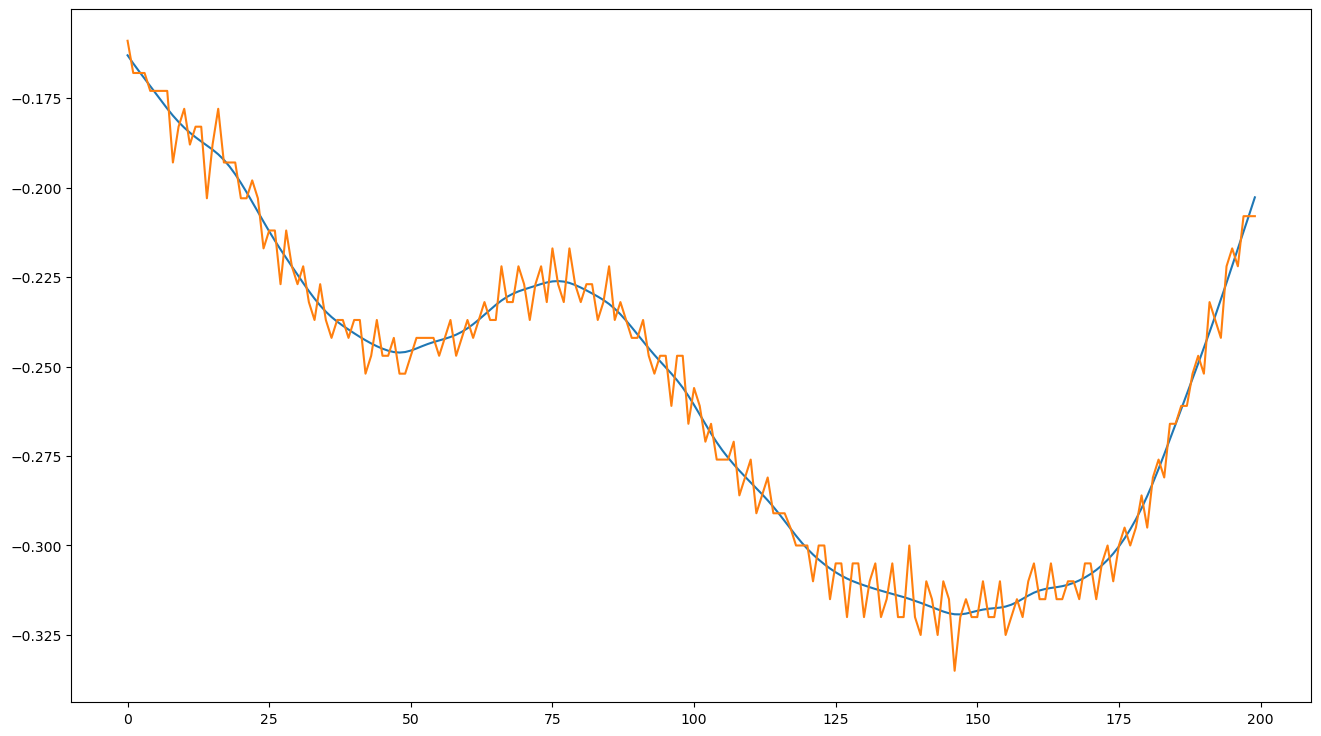

In [5]:
plt.figure(figsize=(16, 9))
plt.plot(data[1000:1200])
plt.plot(data_no_filter[1000:1200])

Text(0.5, 0, 'time, ms^-2')

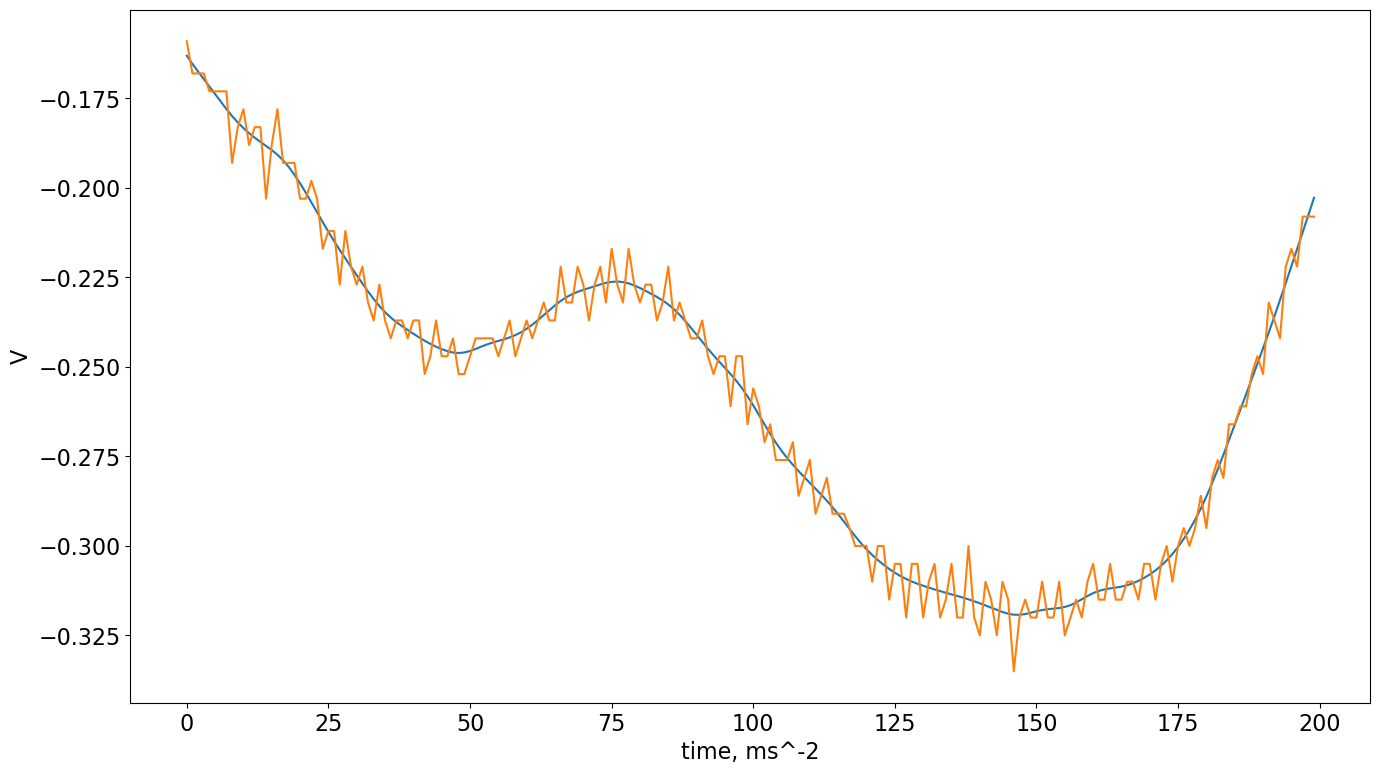

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(data[1000:1200])
ax.plot(data_no_filter[1000:1200])

ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title('LSTM')
ax.set_ylabel("V",  fontsize = 16)
ax.set_xlabel("time, ms^-2",  fontsize = 16)

In [7]:
data_filtered = gaussian_filter(data[::100] , sigma=3, radius=20)

In [8]:
data_resampled = sps.resample(data, len(data) // 100)

Text(0.5, 0, 'time, ms')

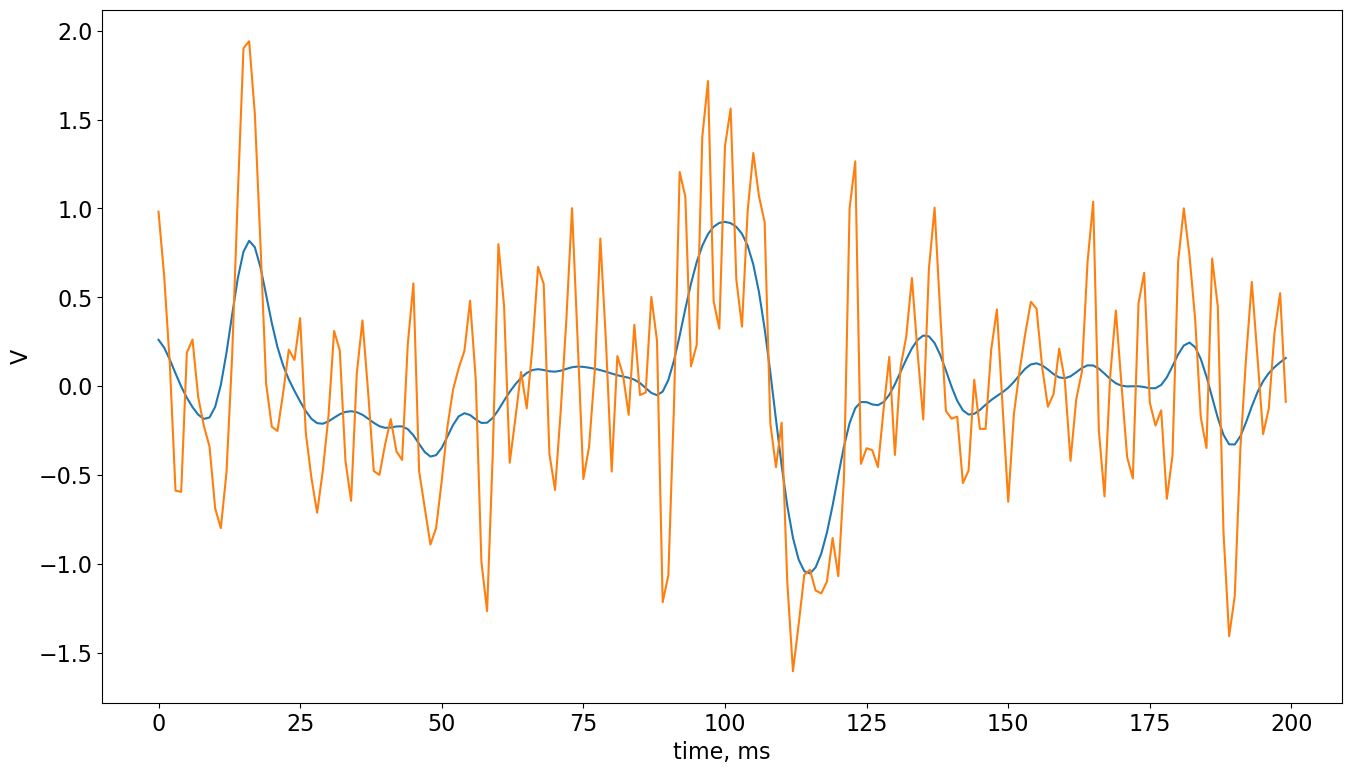

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(data_filtered[1000:1200])
ax.plot(data_resampled[1000:1200])

ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title('LSTM')
ax.set_ylabel("V",  fontsize = 16)
ax.set_xlabel("time, ms",  fontsize = 16)

Text(0.5, 0, 'time, ms')

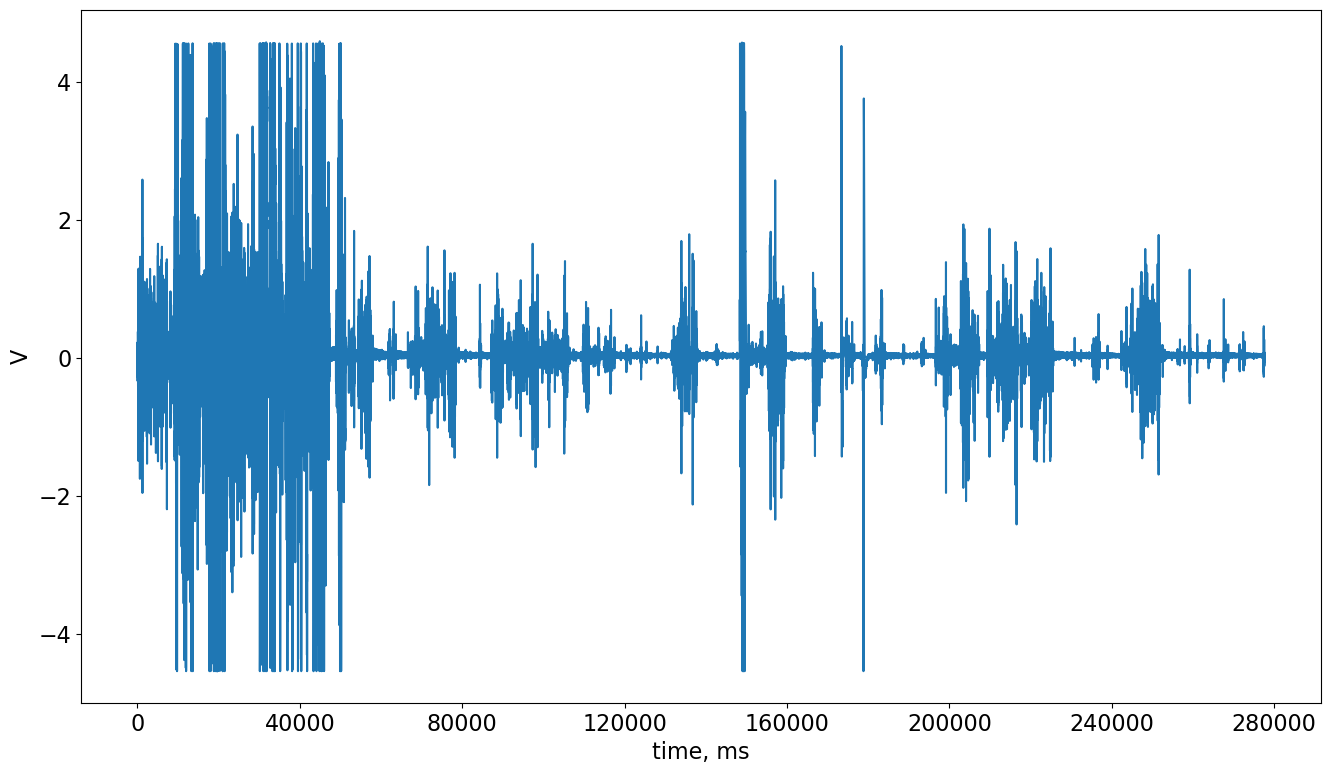

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


ax.plot(data_filtered)

ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title('LSTM')
ax.set_ylabel("V",  fontsize = 16)
ax.set_xlabel("time, ms",  fontsize = 16)

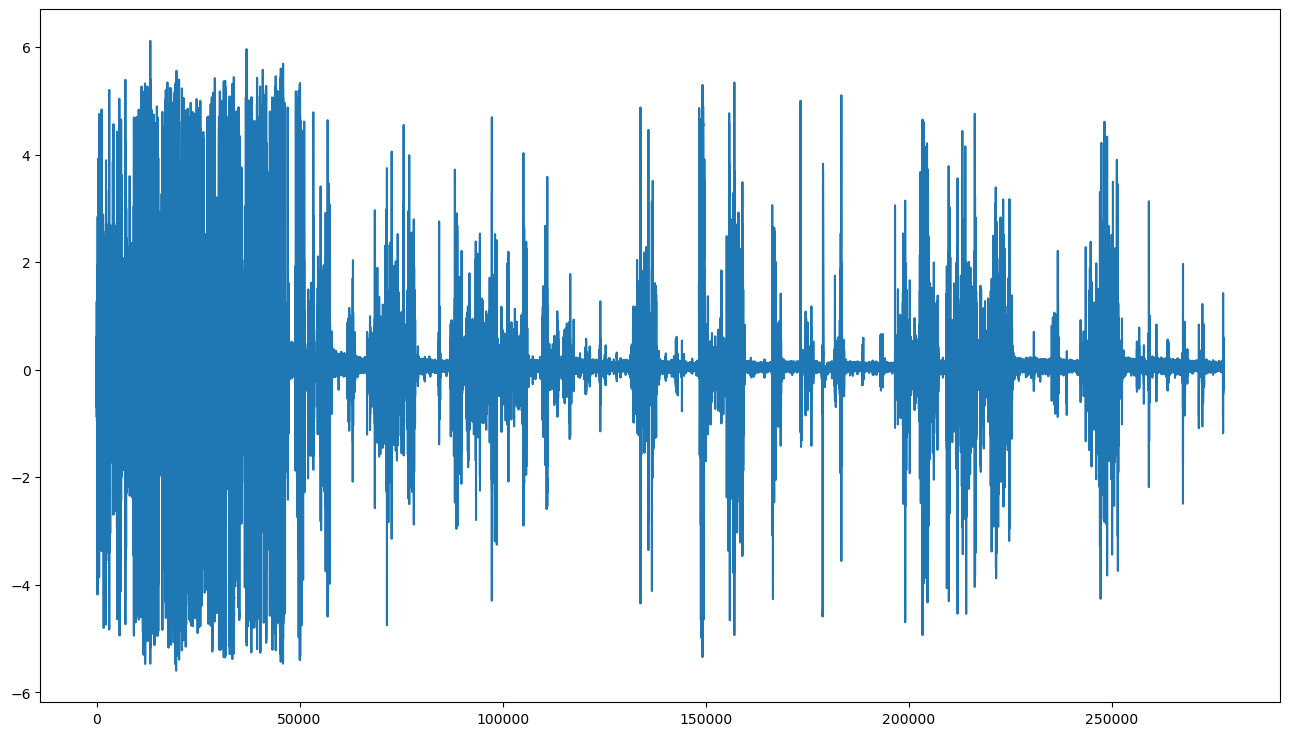

In [63]:
plt.figure(figsize=(16, 9))
plt.plot(data_resampled)

In [14]:
data.shape

(27764733,)

In [44]:
27764733 / 5

5552946.6

In [19]:
277648 / 5

55529.6

In [9]:
len(data_filtered)

277648

In [9]:
#data = np.loadtxt("pilo_pyr3_05022017_clean.txt")

#data = data[::100] 
data = data_filtered

train = data[:-55529]
test =  data[-55529:]

# train = data[:-5552946]
# test =  data[-5552946:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [11]:
# lstm_train = data[:-5552946]
# lstm_test =  data[-5552946:]

lstm_train = data[:-55529]
lstm_test =  data[-55529:]

mean = lstm_train.mean()
std = lstm_train.std()
#sigmastest = np.abs(test - mean)
train_norm = (lstm_train - mean)/std
test_norm = (lstm_test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [12]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in tqdm(range(L-tw)):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

100%|█████████████████████████████████████████████████████████████████████████| 55509/55509 [00:00<00:00, 75904.99it/s]


In [13]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

In [14]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model_lstm = model_lstm.to('cuda')

In [26]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(tqdm(dataloader)):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

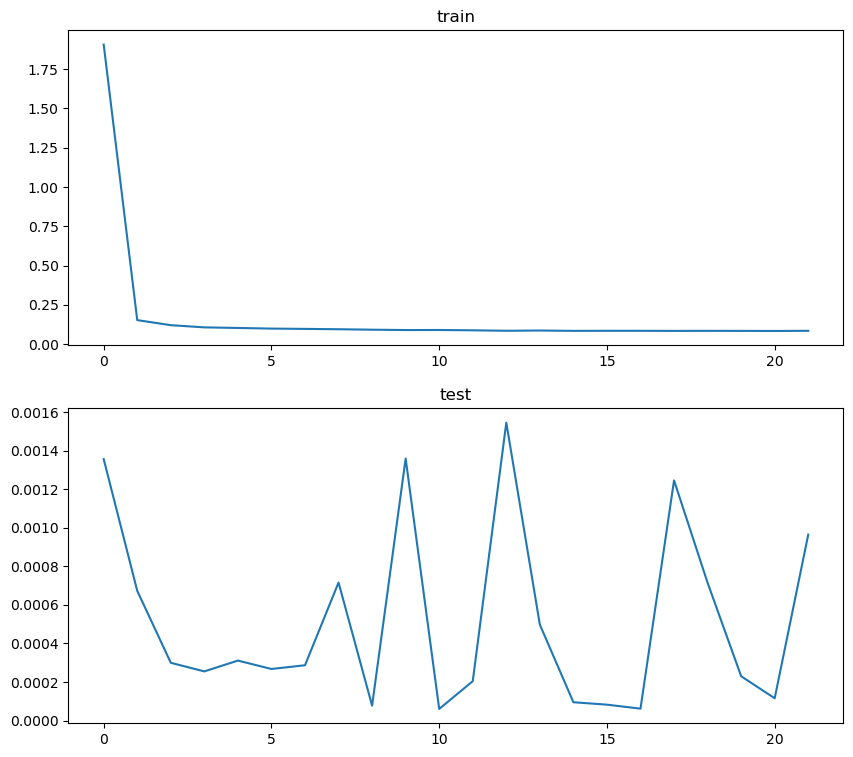

Epoch[22/175] | loss train:0.084523, test:0.000964


 30%|███████████████████████▍                                                     | 1056/3470 [00:03<00:07, 326.62it/s]


KeyboardInterrupt: 

In [29]:
# define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.0001
epochs = 30

losses_train = []
losses_test = []
best_loss = 10e9

# begin training
for epoch in range(epochs): 
     if epoch > 8:
        lr = 0.00005
#     if epoch > 100:
#         lr = 0.0001
    optimizer = optim.Adam(model_lstm.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)    
    loss_train = run_epoch(model_lstm, train_dataloader, is_training=True)
    loss_val = run_epoch(model_lstm, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(model_lstm.state_dict(), "./LSTMMiseDataFilteredDiscrFiltered28.05")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [15]:
model_lstm.load_state_dict(torch.load("./LSTMMiseDataFilteredDiscrFiltered28.05"))

<All keys matched successfully>

In [16]:
def GetRmse(model, train_dataloader, val_dataloader, lstm_test, std, mean):
    model.eval()

    rmse = []
    
    lstm_predicts = []
    for k in tqdm(range(1, 20)):
        test_right_part = (len(lstm_test)- 20)%64
        predicted_val = np.array([])
        for idx, (x, y) in enumerate(val_dataloader):
            x = torch.reshape(x, (64, 20, 1)).to('cuda')
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
            
        lstm_predicts.append(np.array(predicted_val)*std+mean)
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(lstm_test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(lstm_test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse, lstm_predicts

In [17]:
rmse_chaos, lstm_predicts = GetRmse(model_lstm, train_dataloader, test_dataloader, lstm_test, std, mean)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.63s/it]


In [77]:
# np.save("predicts/lstm_filtered_rmse", np.array(rmse_chaos))
# for i in range(len(lstm_predicts)):
#     np.save("predicts/lstm_filtered_predict_" + str(i), lstm_predicts[i])

In [49]:
lstm_rmse = np.load("predicts/lstm_rmse.npy")

In [50]:
rmse_chaos = np.load("predicts/lstm_filtered_rmse.npy")

In [34]:
lstm_rmse

array([0.22837577, 0.31668034, 0.33711585, 0.33972706, 0.34143574,
       0.34234542, 0.34370816, 0.34648878, 0.34936514, 0.35208269,
       0.35417496, 0.35541304, 0.35609414, 0.3563253 , 0.35591581,
       0.35547107, 0.35508458, 0.35485846, 0.35494582])

In [115]:
rmse_chaos

[0.001641742491988641,
 0.00737171508896483,
 0.019901412200205224,
 0.04056095635028662,
 0.06835524486787602,
 0.0997266276003615,
 0.12948171215475482,
 0.15247234761199166,
 0.1653564833099437,
 0.16804337466950578,
 0.1645561163141147,
 0.16257901689150062,
 0.16970953116985943,
 0.18727989441172294,
 0.20936639461348885,
 0.22798679663528668,
 0.2375156732447151,
 0.23661762209673745,
 0.22899904430033458]

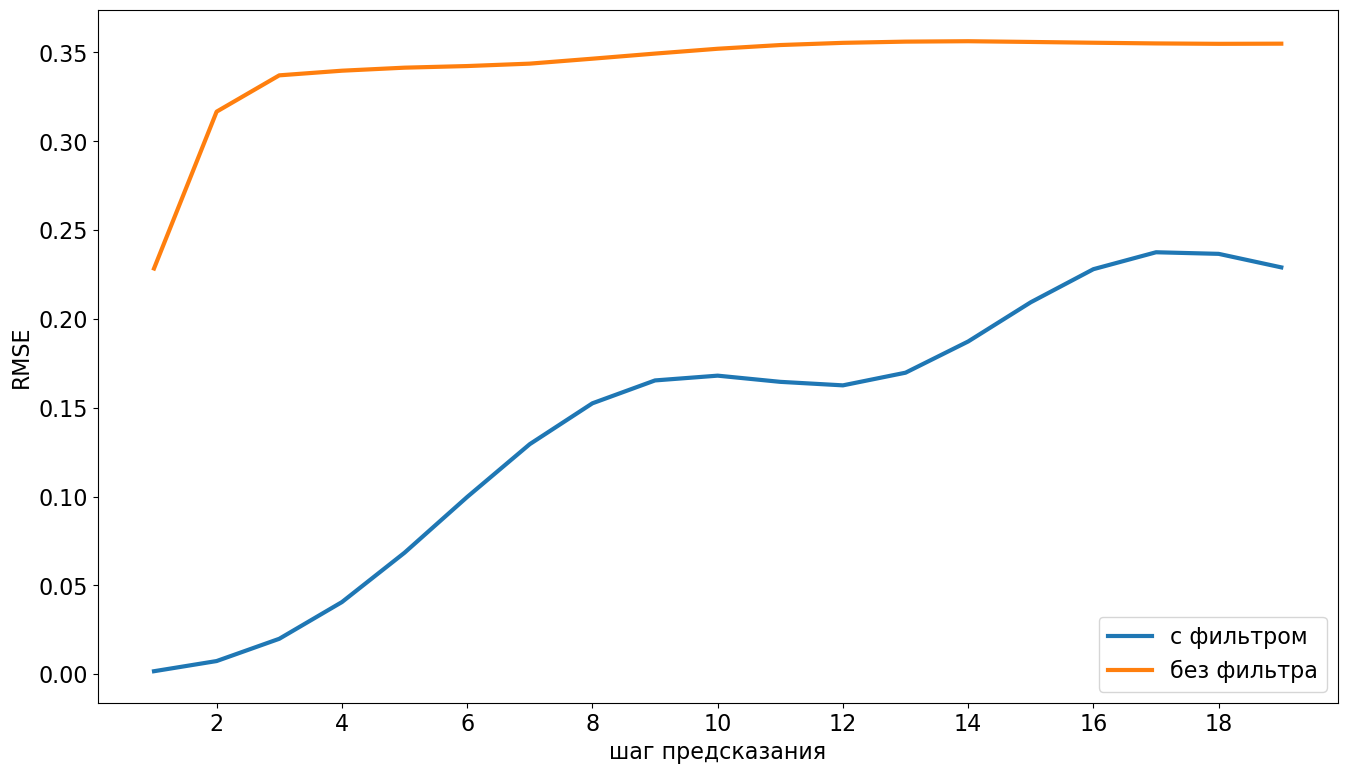

In [52]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), rmse_chaos, label="с фильтром", linewidth = 3)
ax.plot(list(range(1, 20)), lstm_rmse, label="без фильтра", linewidth = 3)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("шаг предсказания",  fontsize = 16)
ax.legend(fontsize = 16)

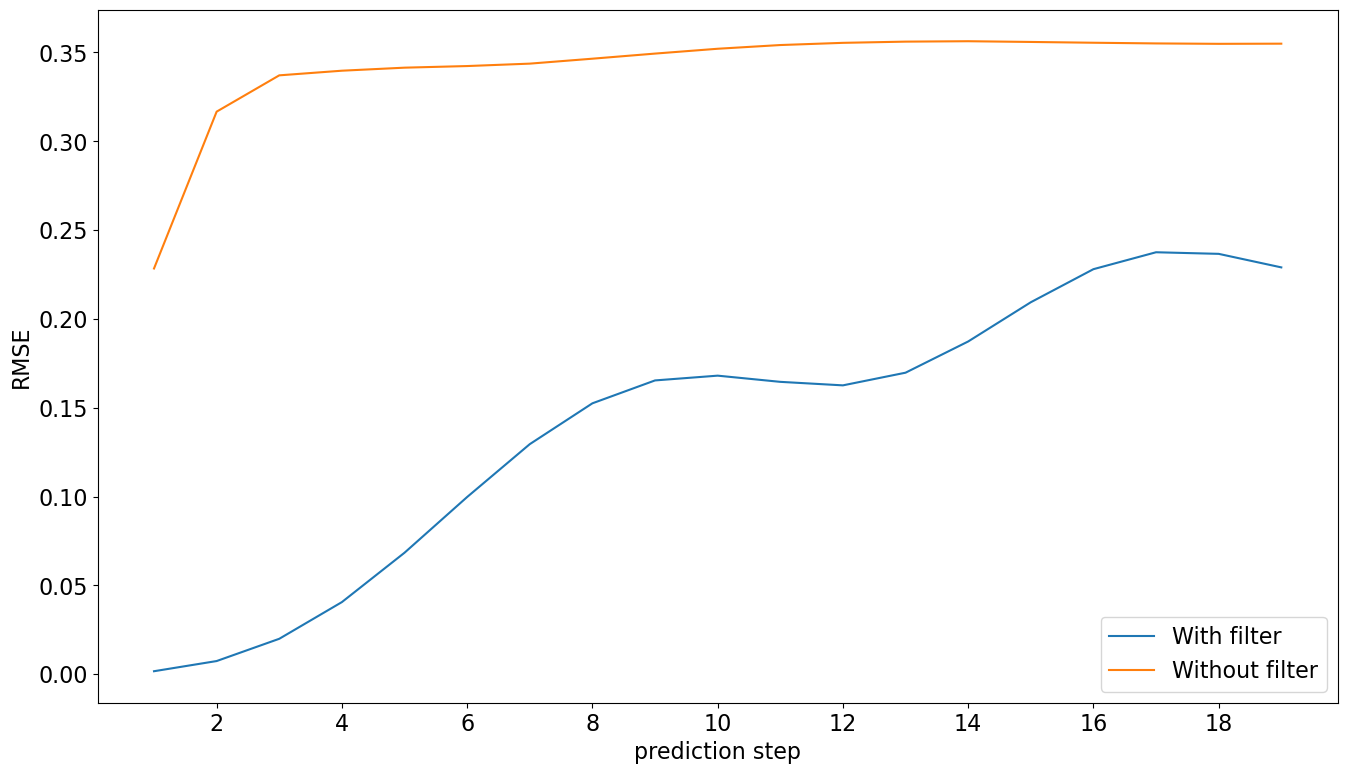

In [79]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), rmse_chaos, label="With filter")
ax.plot(list(range(1, 20)), lstm_rmse, label="Without filter")

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)
ax.legend(fontsize = 16)

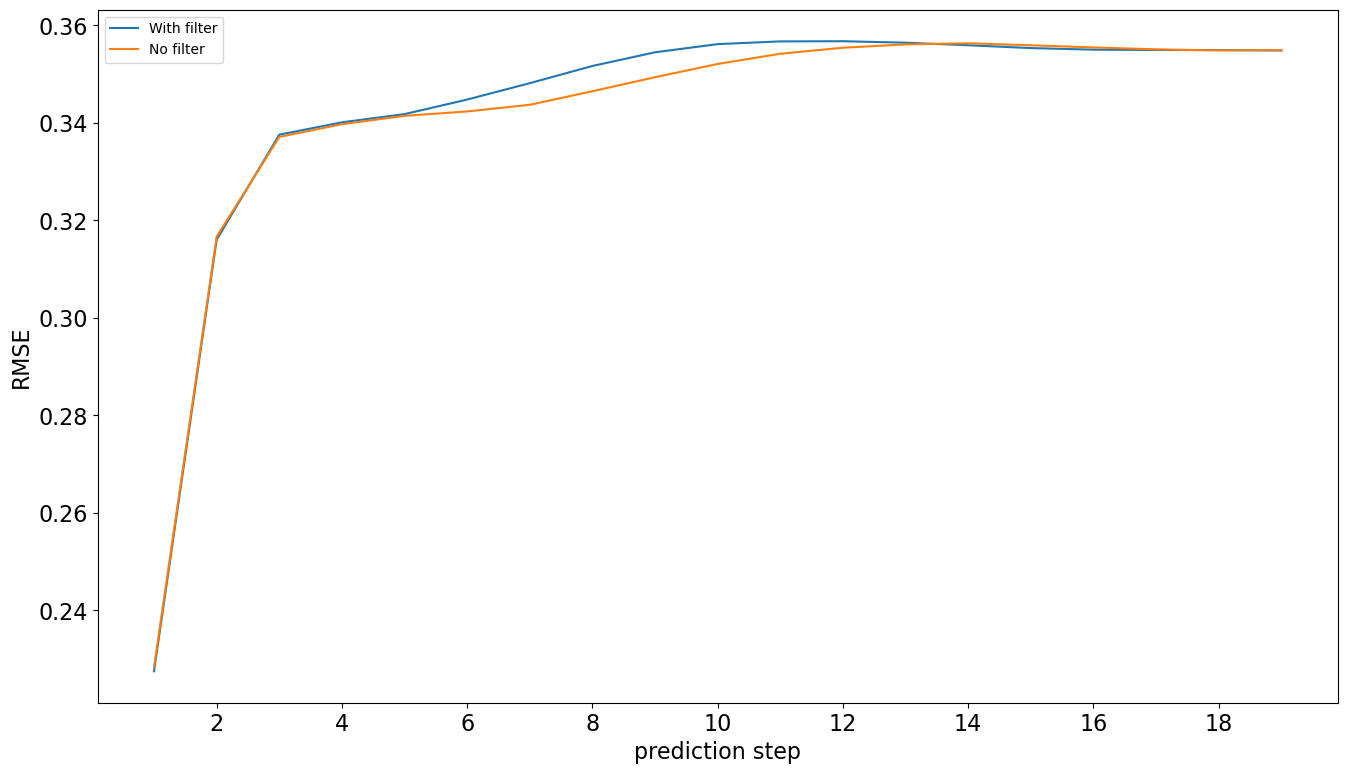

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), rmse_chaos, label="With filter")
ax.plot(list(range(1, 20)), lstm_rmse, label="No filter")

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)
ax.legend()

Text(0.5, 0, 'prediction step')

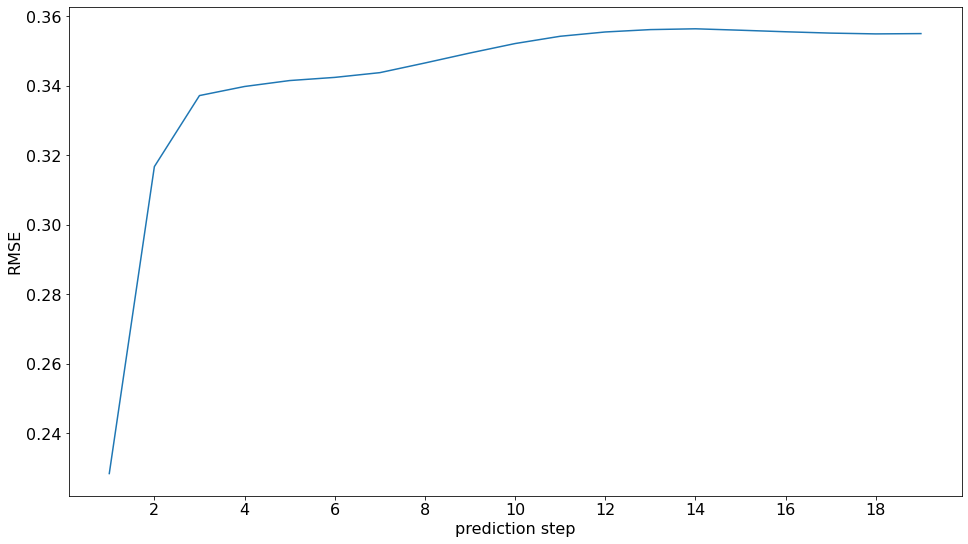

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), lstm_rmse)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

In [47]:
lstm_predicts = []
for i in range(19):
    lstm_predicts.append(np.load("predicts/lstm_filtered_predict_" + str(i) + ".npy"))

In [60]:
def Plt(k):
    #k = 5
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    
    ax.plot(list(range(0, 10000, 10)), lstm_test[20+k-1: 20+k-1 + 1000], linewidth = 3, label='истинные')
    ax.plot(list(range(0, 10000, 10)), lstm_predicts[k-1][:1000],  linestyle = (0, (5, 10)), linewidth = 3, label='предсказанные', color="red")
    #ax.plot(list(range(0, 10000, 10)), lstm_predicts[k-1][:1000],  linestyle = '--', linewidth = 3, label='предсказанные', color="red")
    
    ax.legend(fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title('LSTM')
    ax.set_ylabel("V, мВ",  fontsize = 16)
    ax.set_xlabel("время, мс",  fontsize = 16)
    
    
    plt.show()
    

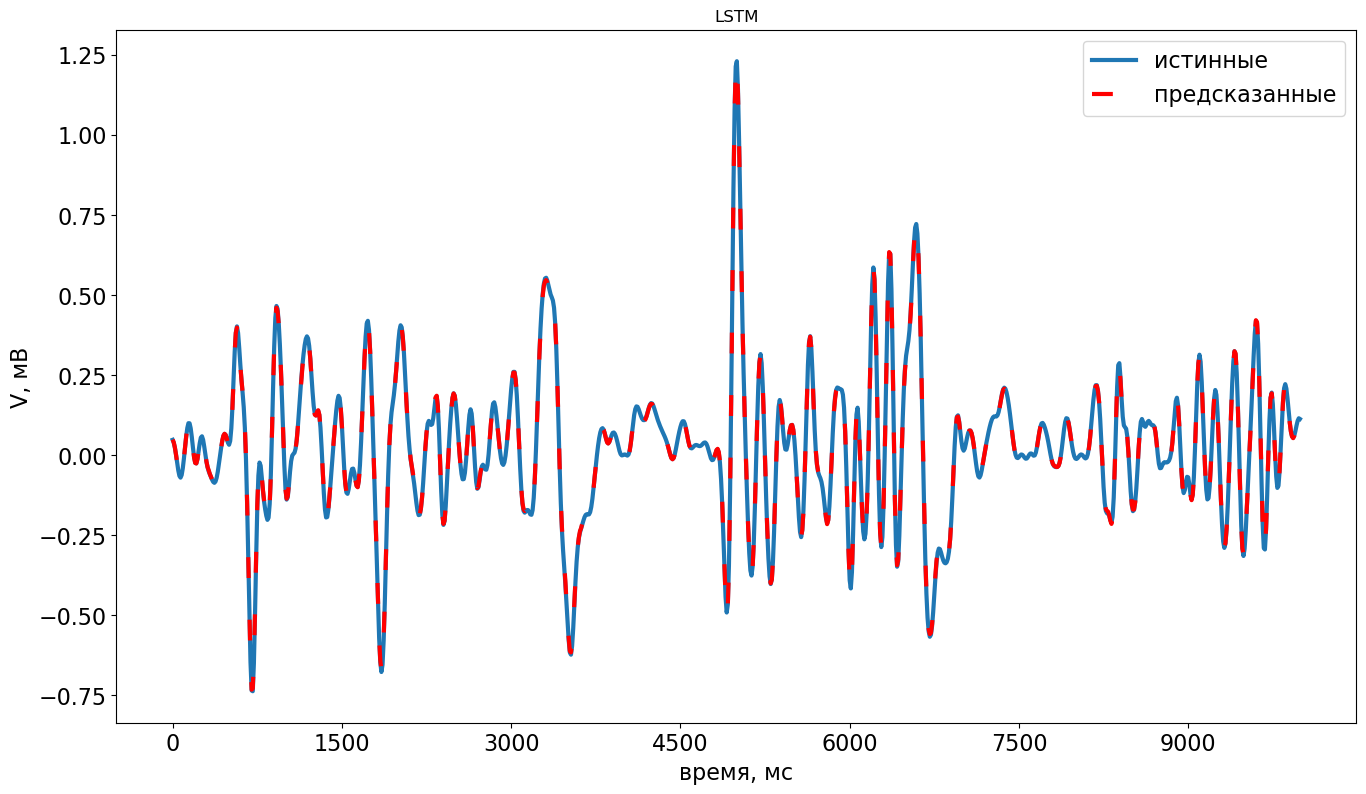

In [44]:
Plt(1)

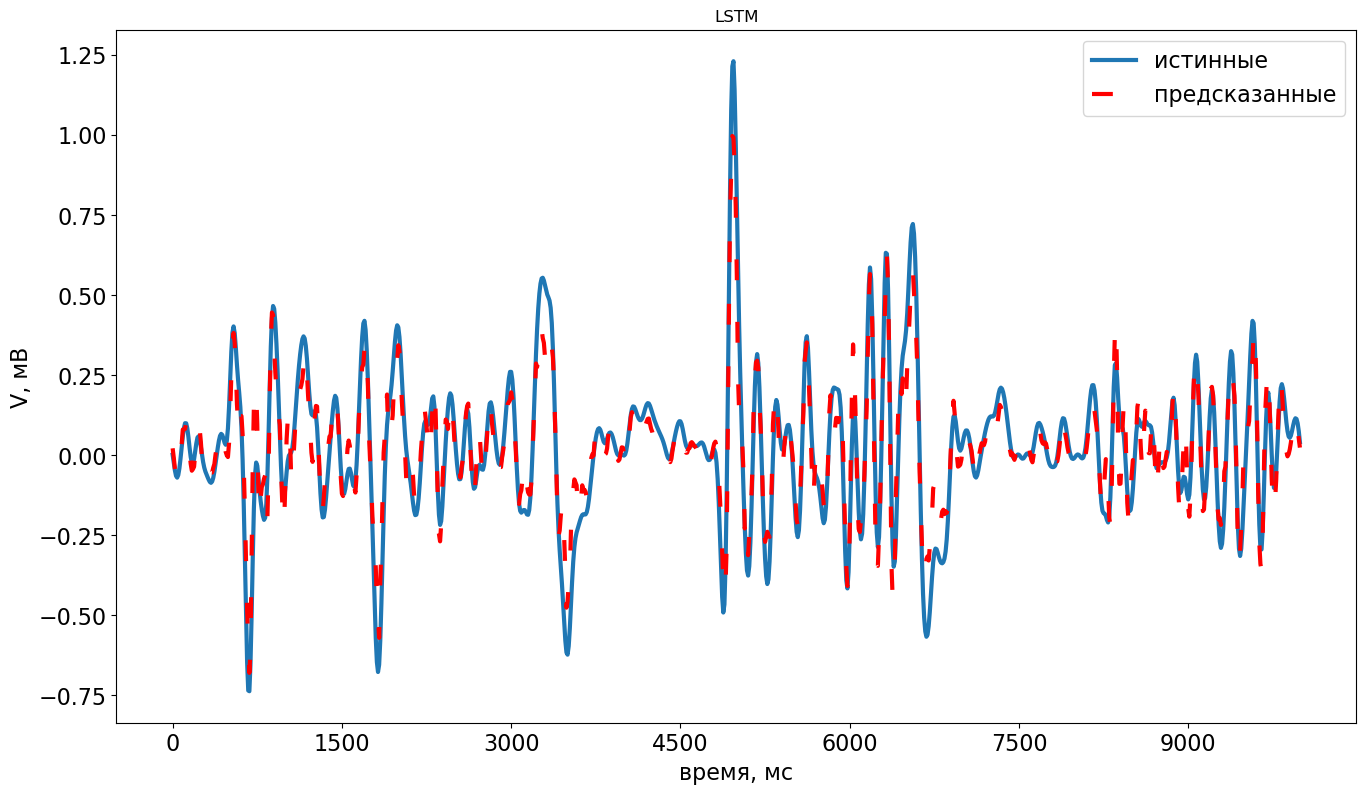

In [48]:
Plt(4)

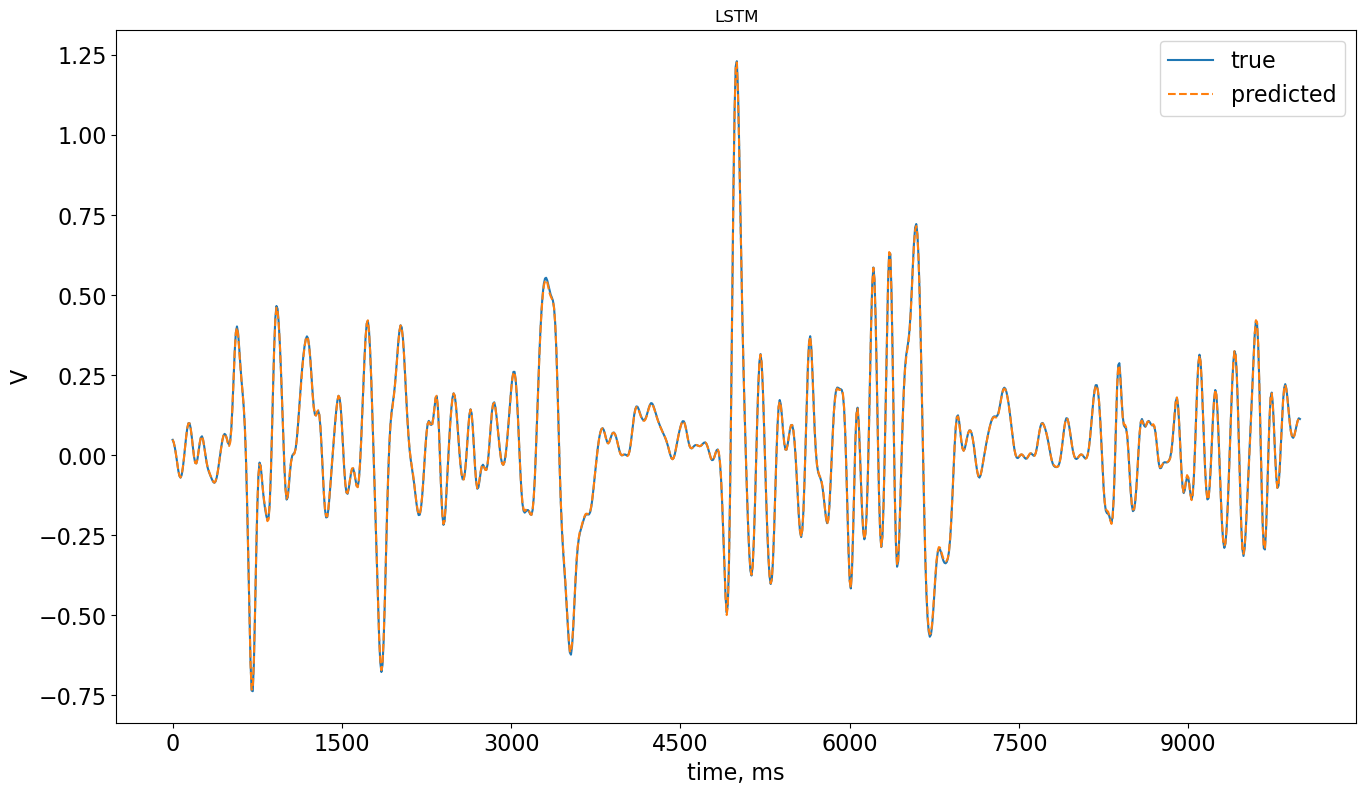

In [71]:
Plt(1)

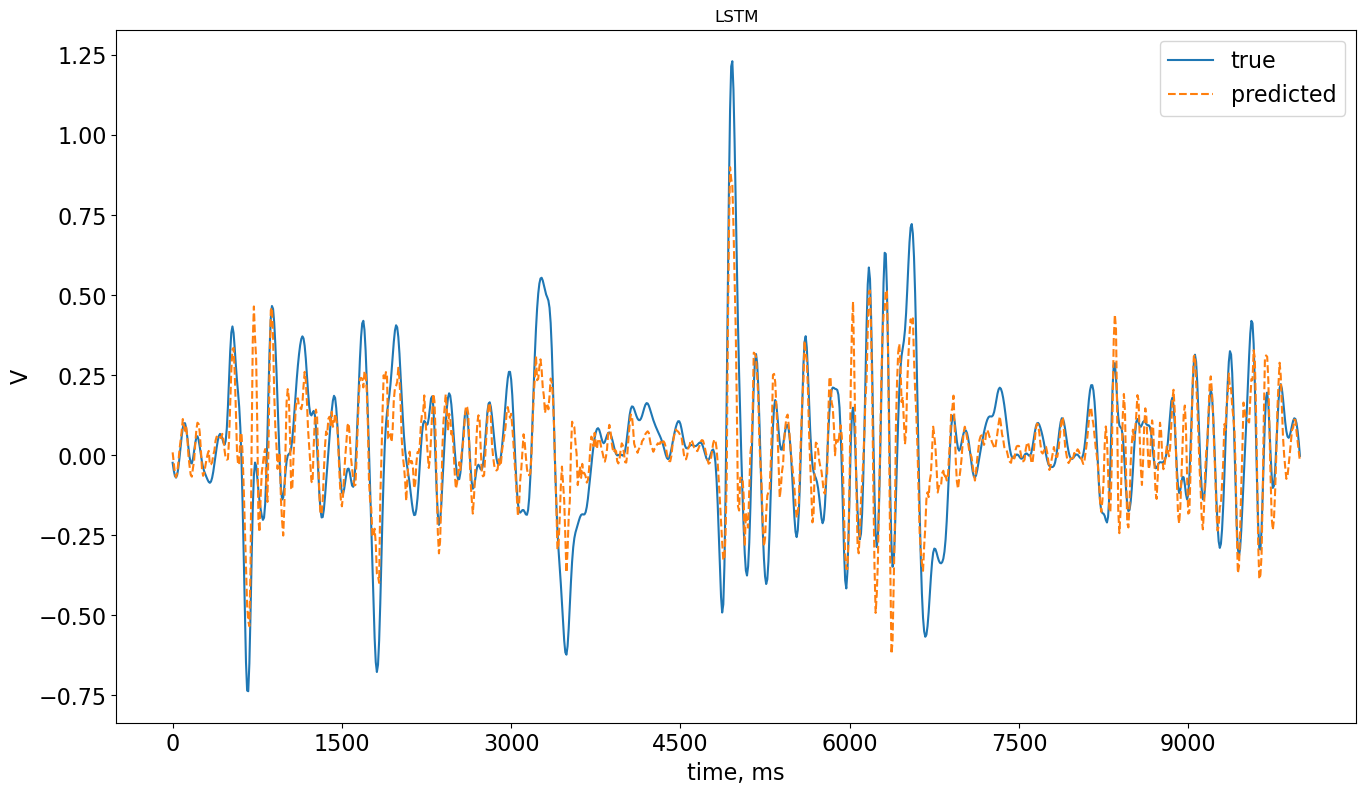

In [72]:
Plt(5)

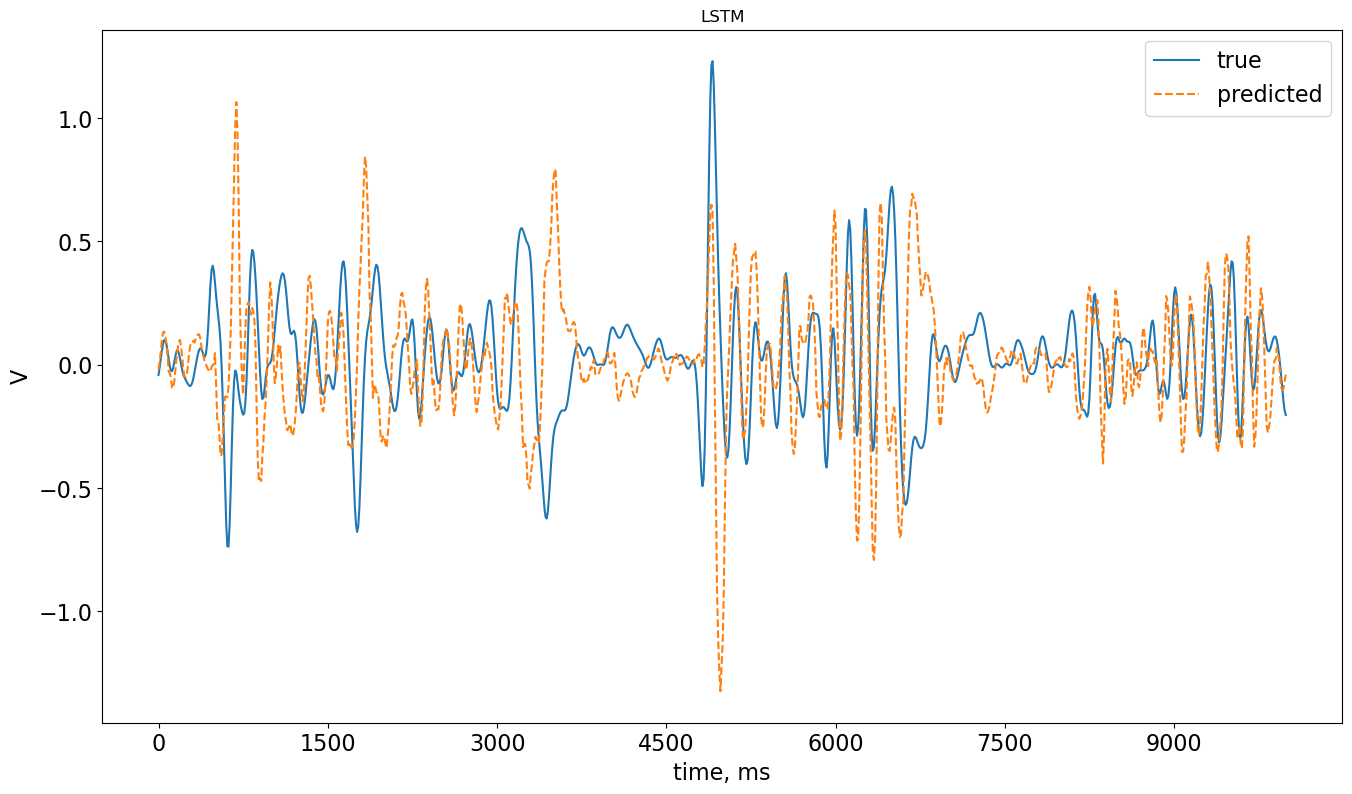

In [101]:
Plt(10)

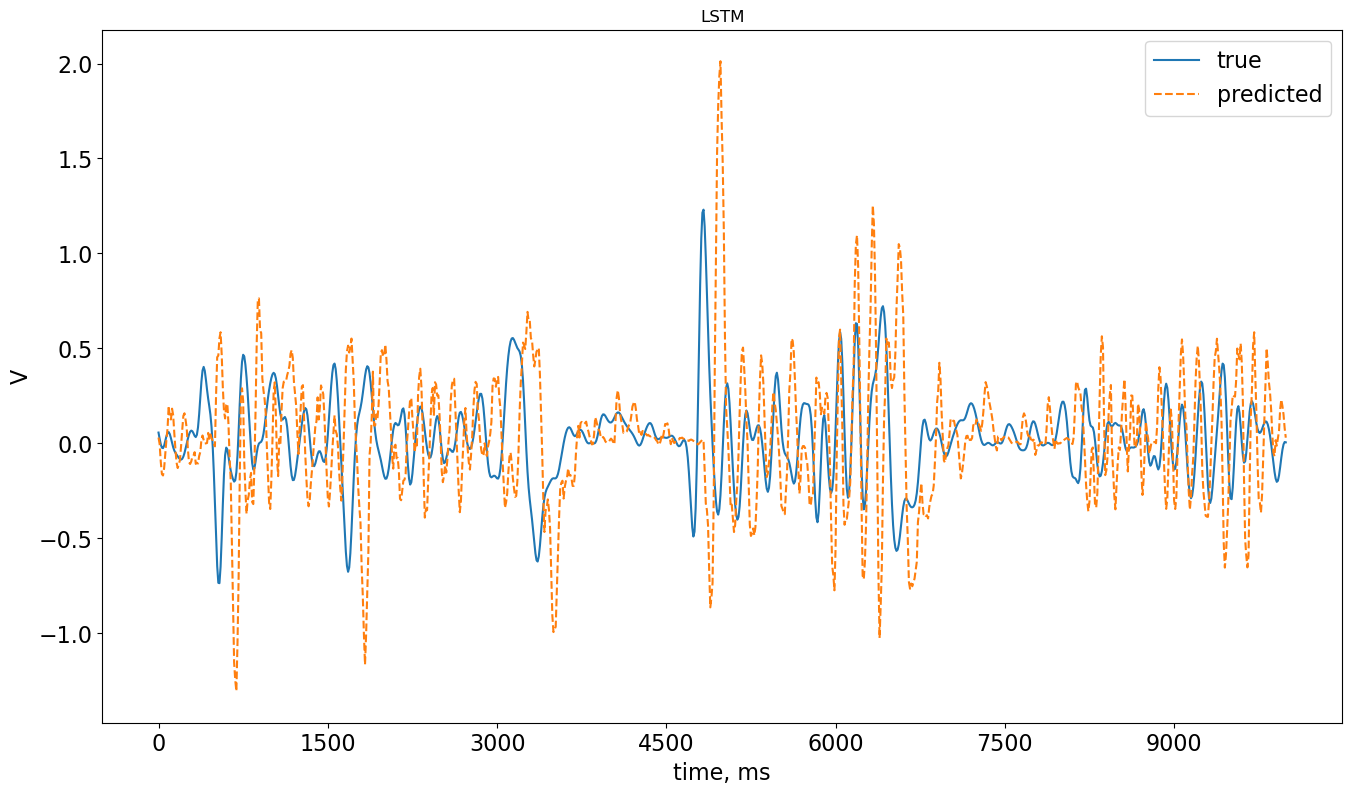

In [109]:
Plt(18)

In [73]:
def PlotDif(k):
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    
    ax.plot(list(range(0, 10000, 10)), np.abs(lstm_test[20+k-1: 20+k-1 + 1000]-lstm_predicts[k-1][:1000]))
   
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title('LSTM')
    ax.set_ylabel("V",  fontsize = 16)
    ax.set_xlabel("time, ms",  fontsize = 16)
    
    
    plt.show()

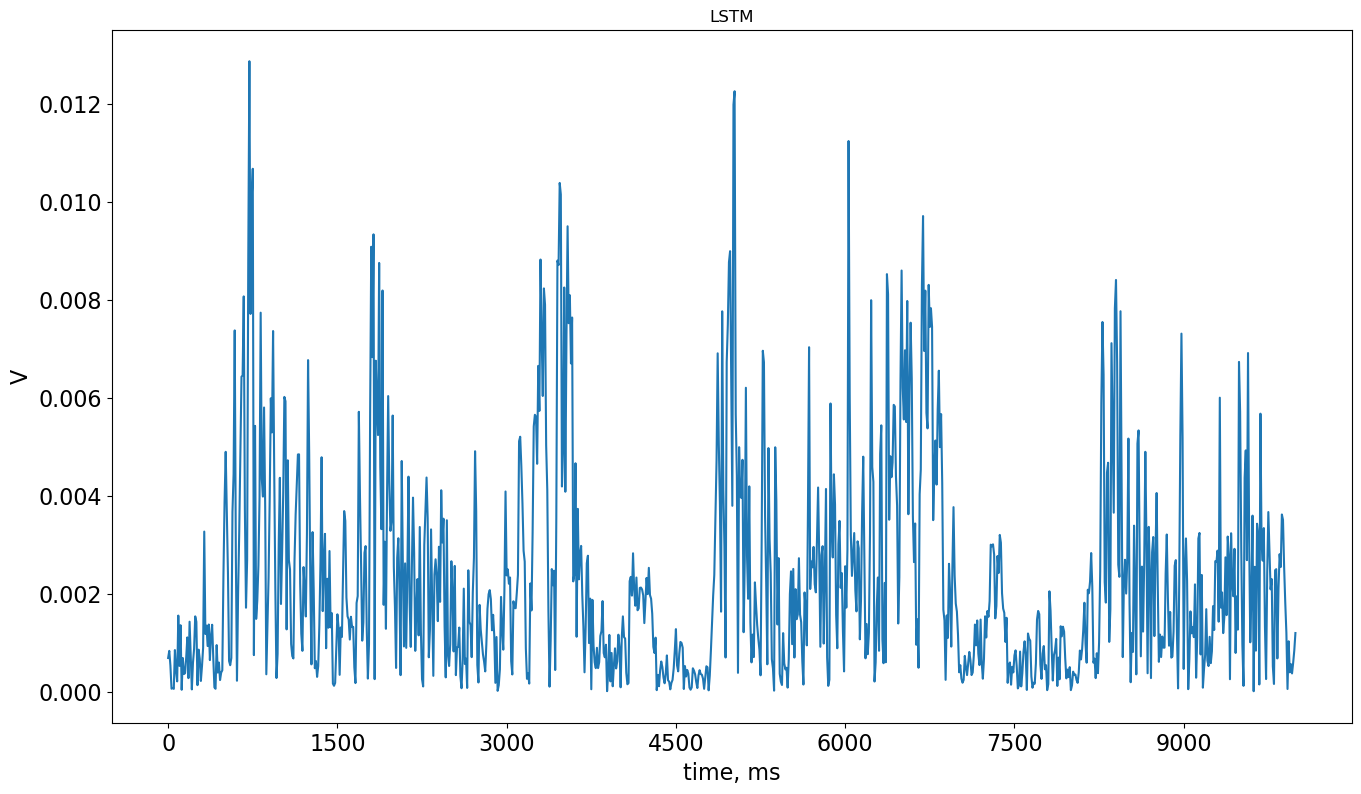

In [74]:
PlotDif(1)

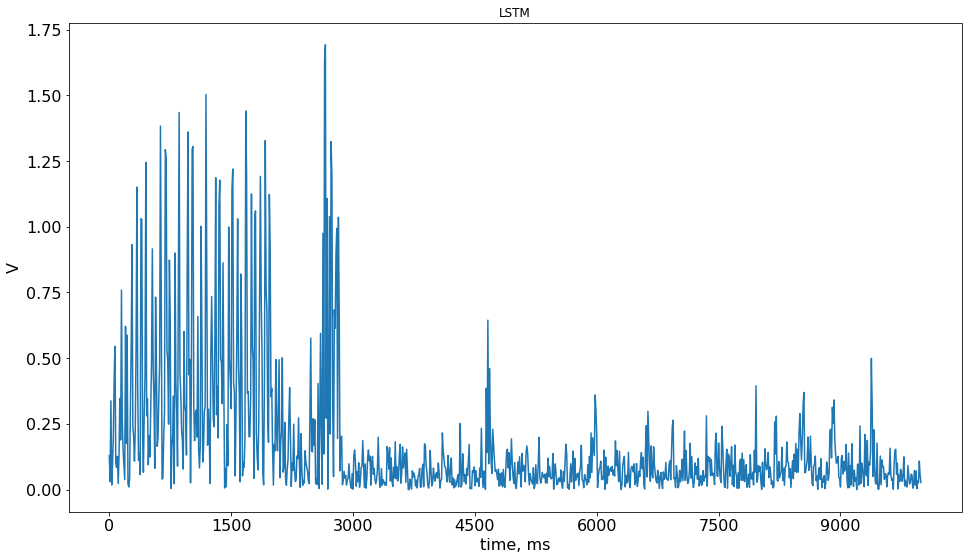

In [8]:
PlotDif(1)

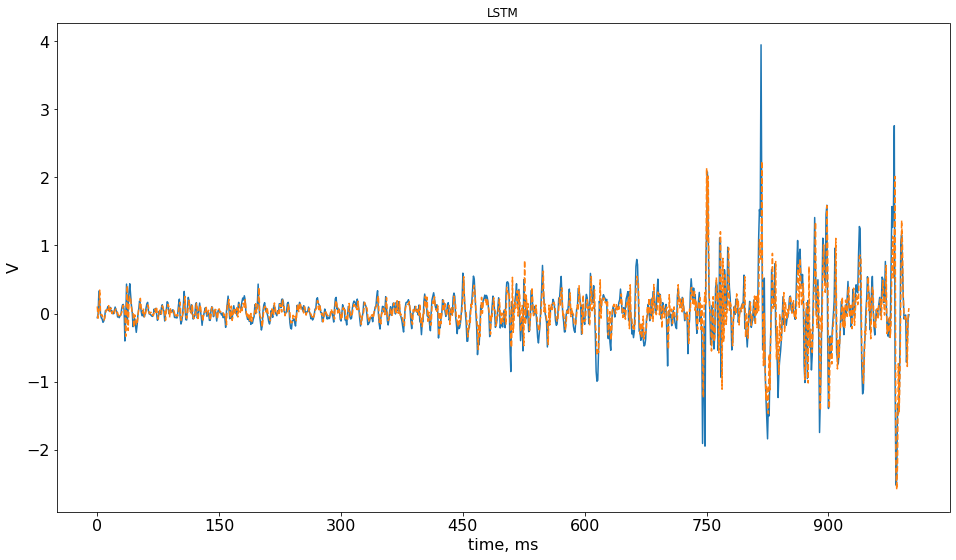

In [15]:
k=1
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


ax.plot(lstm_test[20+k-1: 20+k-1 + 3000][2000:3000], label='true')
ax.plot(lstm_predicts[k-1][2000:3000],  linestyle = '--', label='predicted')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('LSTM')
ax.set_ylabel("V",  fontsize = 16)
ax.set_xlabel("time, ms",  fontsize = 16)


plt.show()

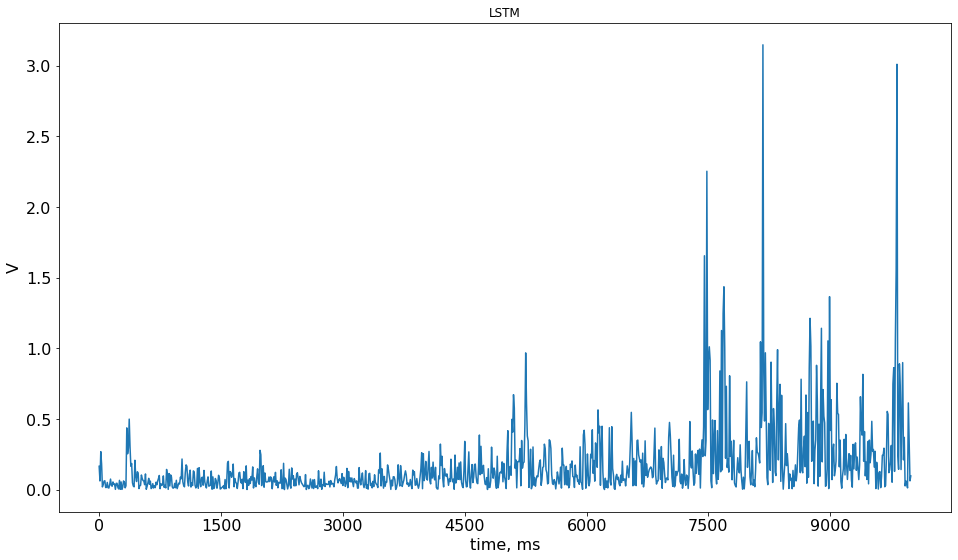

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


ax.plot(list(range(0, 10000, 10)), np.abs(lstm_test[20+k-1: 20+k-1 + 3000][2000:3000]-lstm_predicts[k-1][2000:3000]))

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('LSTM')
ax.set_ylabel("V",  fontsize = 16)
ax.set_xlabel("time, ms",  fontsize = 16)


plt.show()

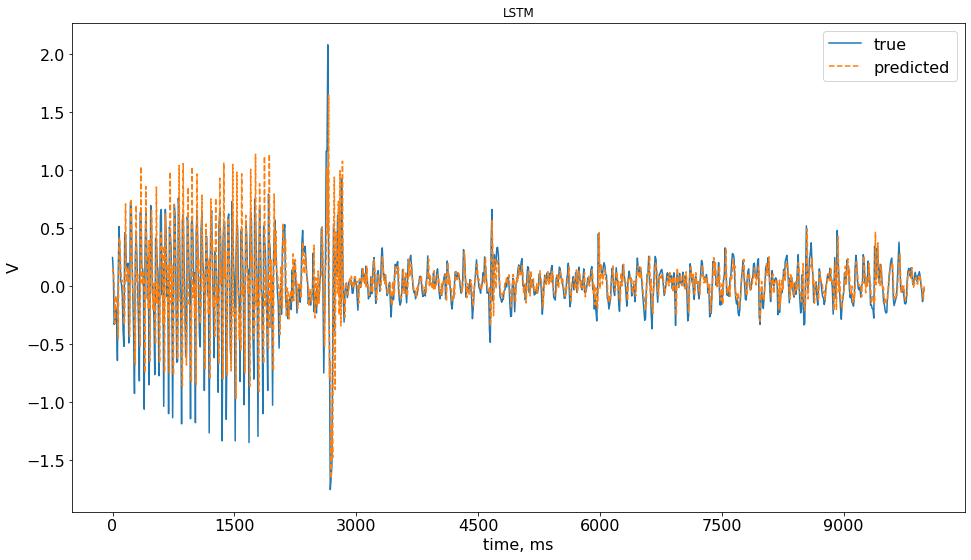

In [24]:
Plt(1)

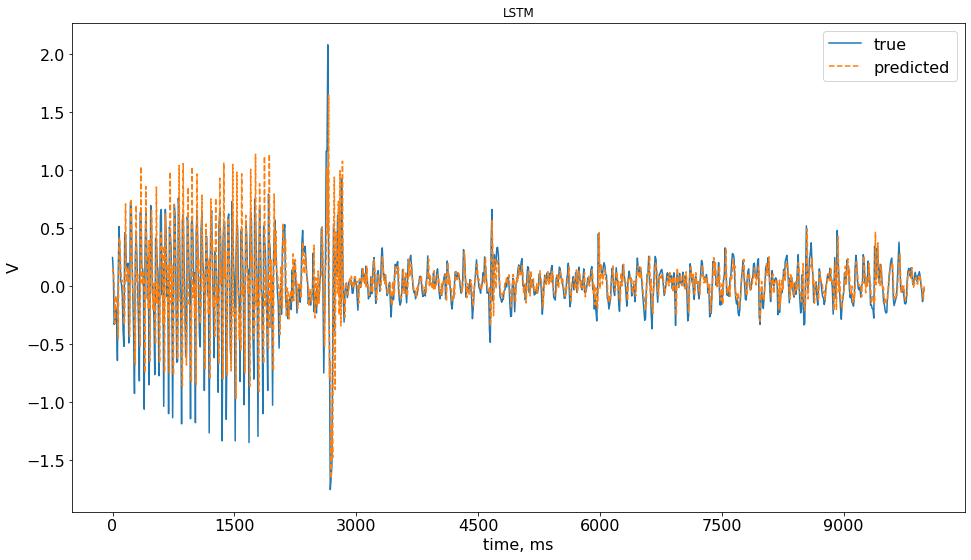

In [19]:
Plt(1)

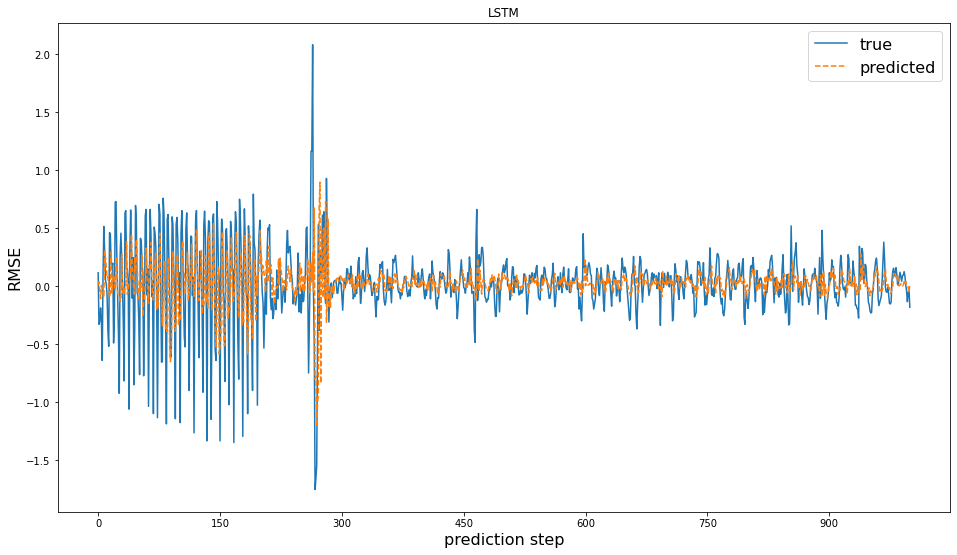

In [16]:
Plt(2)

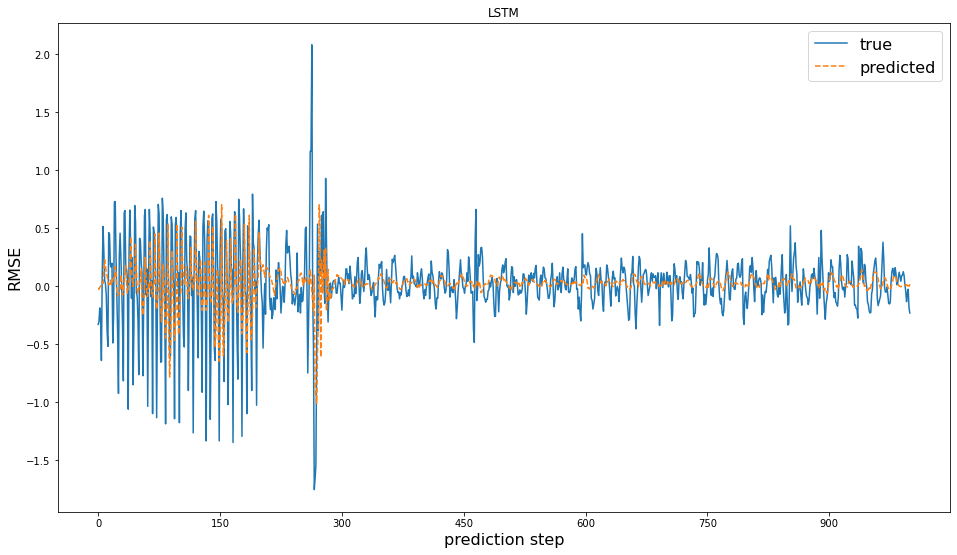

In [17]:
Plt(3)

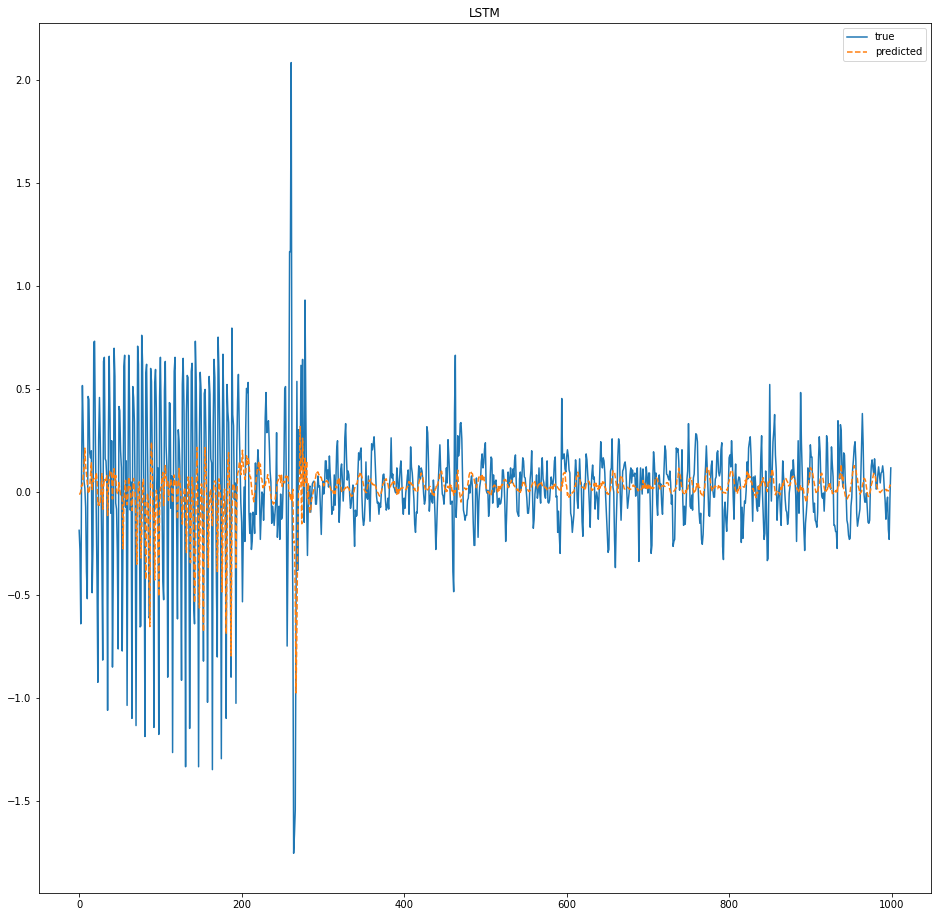

In [17]:
Plt(5)

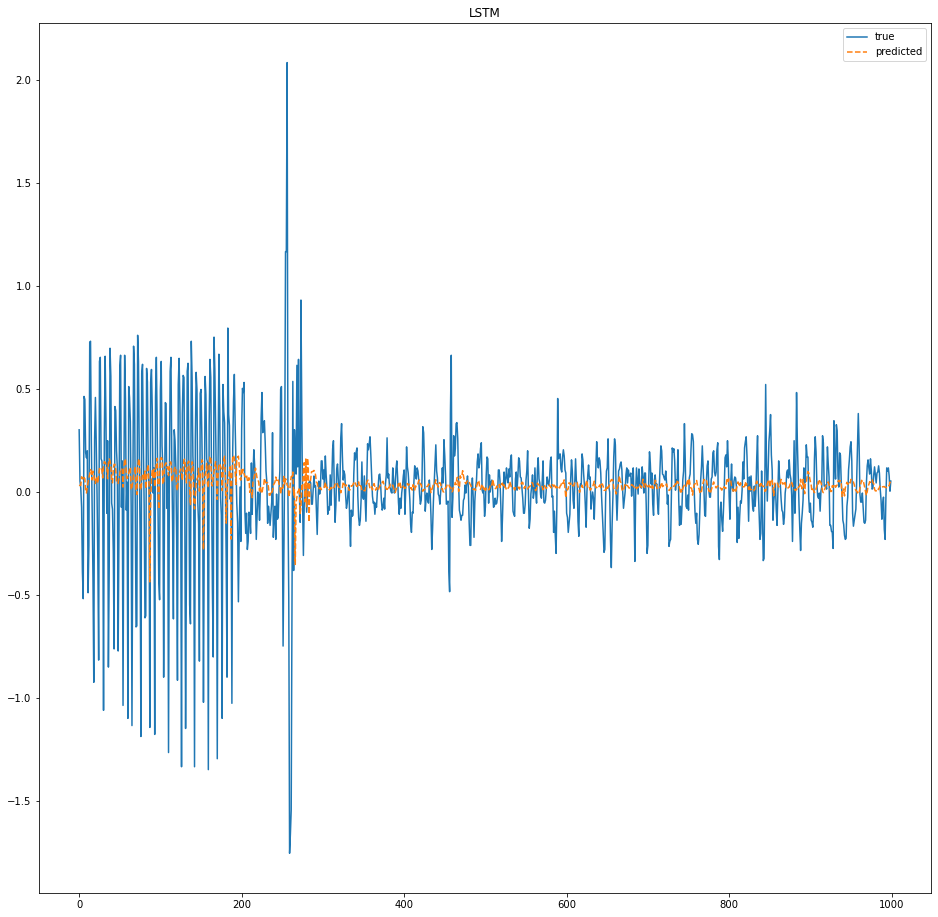

In [18]:
Plt(10)

In [80]:
def Calc_TP(predict, target, k, n, m):

    assert len(predict) == len(target)

    TP = 0
    i = n
    TP_lst = []
    while i < len(predict):
        if predict[i] > Hs:
            #print(i)
            if (target[i - k + 1: i + n] > Hs).any() and (target[i-m: i - k + 1] < Hs).all():
                #print(i)
                TP_lst.append(i)
                i += n
                TP += 1
        i += 1
    return TP, TP_lst

In [81]:
lstm_predicts[0][498]

1.0699943771415485

In [82]:
test_right_part = (len(lstm_test)- 20)%64

TP_lstm, _ = Calc_TP(lstm_predicts[0], lstm_test[20:-test_right_part], 1, 50, 5)
TP_lstm

16

In [68]:
def Calc_FN(predict, target, k, n, m):

    assert len(predict) == len(target)

    FN = 0
    i = n
    FN_lst = []
    while i < len(predict):
        if target[i] > Hs:
            if (predict[i - n: i + k] < Hs).all():
                #print(i)
                #return FN
                FN_lst.append(i)
                i += n
                FN += 1
        i += 1
    return FN, FN_lst

In [69]:
def Calc_FP(predict, target, k, n, m):

    assert len(predict) == len(target)

    FP = 0
    i = n
    FP_lst = []
    while i < len(predict):
        if predict[i] > Hs:
            if (target[i - n: i + n] < Hs).all():
                #print(i)
                #return FN
                FP_lst.append(i)
                i += n
                FP += 1
        i += 1
    return FP, FP_lst

In [64]:
Hs = 1

In [38]:
test_right_part = (len(test)- 20)%64

TP_lstm, _ = Calc_TP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
FN_lstm, _ = Calc_FN(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
FP_lstm, _ = Calc_FP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)

In [88]:
TP_lstm / (TP_lstm + FN_lstm)

1.0

In [55]:
FP_lstm

4

In [50]:
6/27

0.2222222222222222

In [83]:
test_right_part = (len(test)- 20)%64
TPs_lstm = []

for i in range(19):
    
    if i:
        TP_lstm, _ = Calc_TP(lstm_predicts[i][:-i], lstm_test[20+i:-test_right_part], i+1, 50, 5 + i)
        TPs_lstm.append(TP_lstm)
    else:
        TP_lstm, _ = Calc_TP(lstm_predicts[0], lstm_test[20:-test_right_part], 1, 50, 5)
        TPs_lstm.append(TP_lstm)
    

In [84]:
test_right_part = (len(test)- 20)%64
FNs_lstm = []

for i in range(19):
    
    if i:
        FN_lstm, _ = Calc_FN(lstm_predicts[i][:-i], lstm_test[20+i:-test_right_part], i+1, 50, 5 + i)
        FNs_lstm.append(FN_lstm)
    else:
        FN_lstm, _ = Calc_FN(lstm_predicts[0], lstm_test[20:-test_right_part], 1, 50, 5)
        FNs_lstm.append(FN_lstm)
    

In [85]:
test_right_part = (len(test)- 20)%64
FPs_lstm = []

for i in range(19):

    if i:
        FP_lstm, _ = Calc_FP(lstm_predicts[i][:-i], lstm_test[20+i:-test_right_part], i+1, 50, 5 + i)
        FPs_lstm.append(FP_lstm)
    else:
        FP_lstm, _ = Calc_FP(lstm_predicts[0], lstm_test[20:-test_right_part], 1, 50, 5)
        FPs_lstm.append(FP_lstm)
    

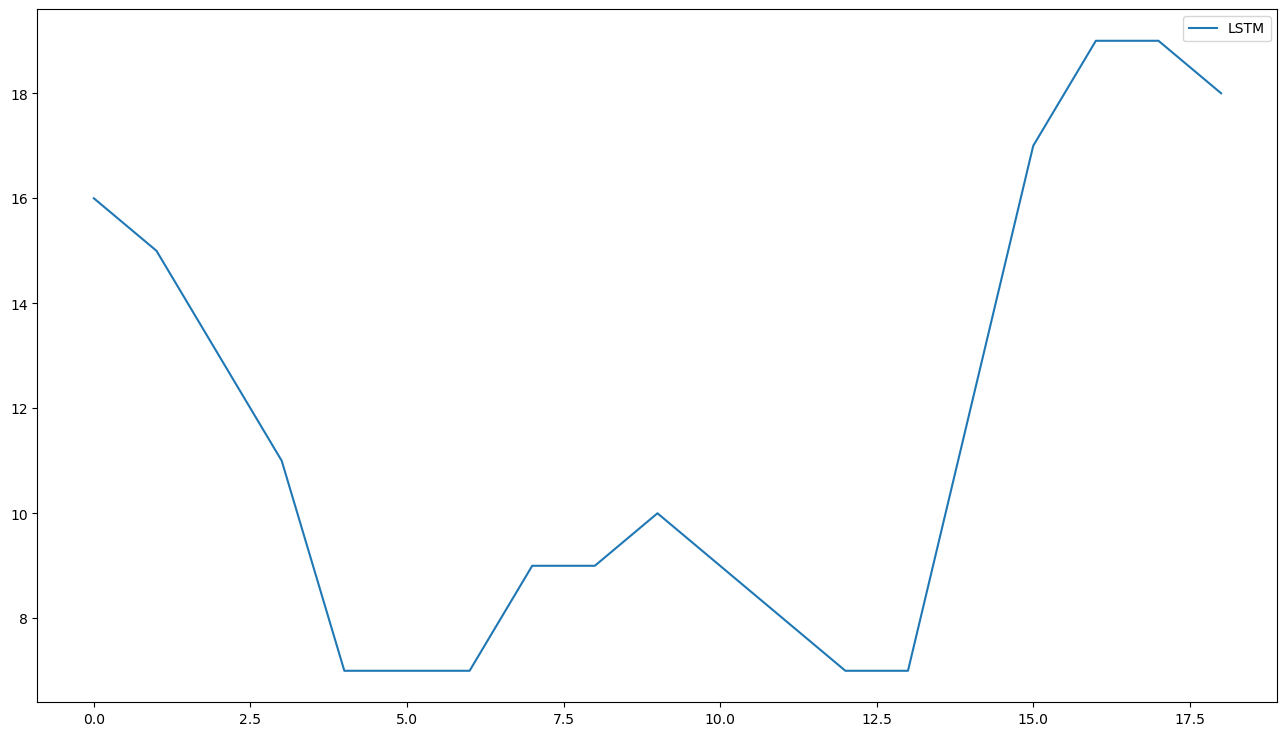

In [86]:
plt.figure(figsize=(16, 9))
plt.plot(TPs_lstm, label="LSTM")
plt.legend()

In [87]:
acc = []
for i in range(len(TPs_lstm)):
    acc.append(TPs_lstm[i] / (TPs_lstm[i] + FNs_lstm[i]))

In [88]:
acc

[1.0,
 0.8823529411764706,
 0.7647058823529411,
 0.6111111111111112,
 0.3888888888888889,
 0.4117647058823529,
 0.4375,
 0.5625,
 0.5625,
 0.625,
 0.5625,
 0.5,
 0.4375,
 0.4375,
 0.7058823529411765,
 1.0,
 1.0,
 1.0,
 1.0]

Text(0.5, 0, 'prediction step')

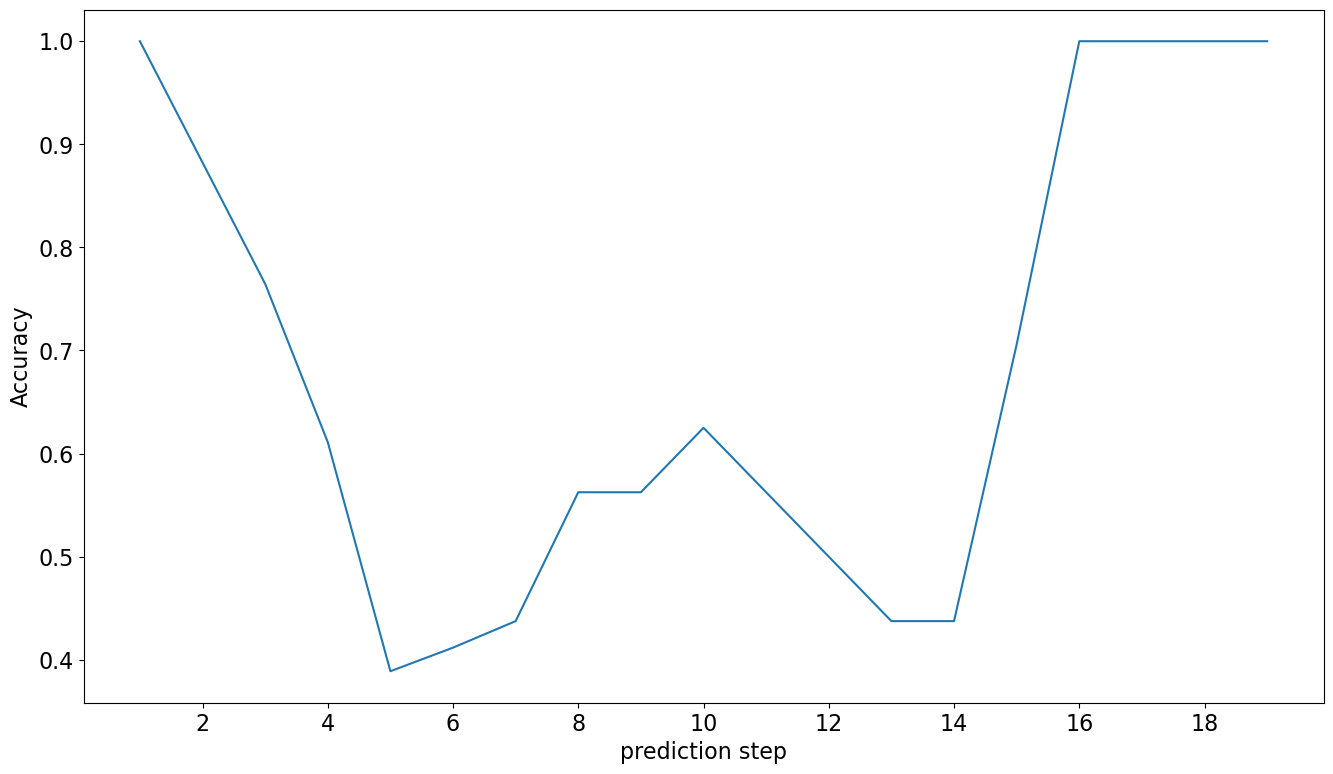

In [89]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), acc)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("Accuracy",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

In [90]:
pres = []
for i in range(len(TPs_lstm)):
    pres.append(TPs_lstm[i] / (TPs_lstm[i] + FPs_lstm[i]))

In [91]:
pres

[1.0,
 1.0,
 1.0,
 0.9166666666666666,
 1.0,
 0.875,
 0.5384615384615384,
 0.5,
 0.45,
 0.5,
 0.5,
 0.42105263157894735,
 0.3684210526315789,
 0.3684210526315789,
 0.375,
 0.425,
 0.4418604651162791,
 0.4634146341463415,
 0.46153846153846156]

Text(0.5, 0, 'prediction step')

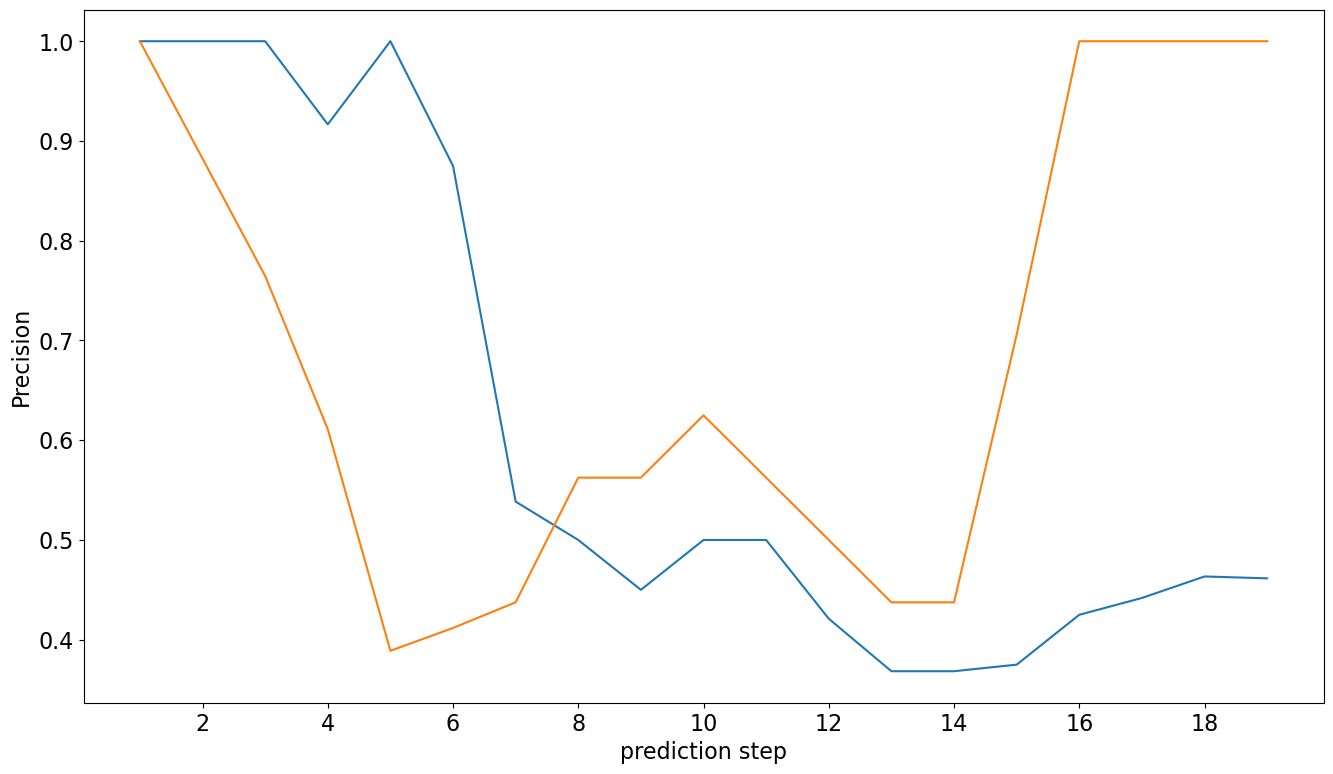

In [92]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), pres)
ax.plot(list(range(1, 20)), acc)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("Precision",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

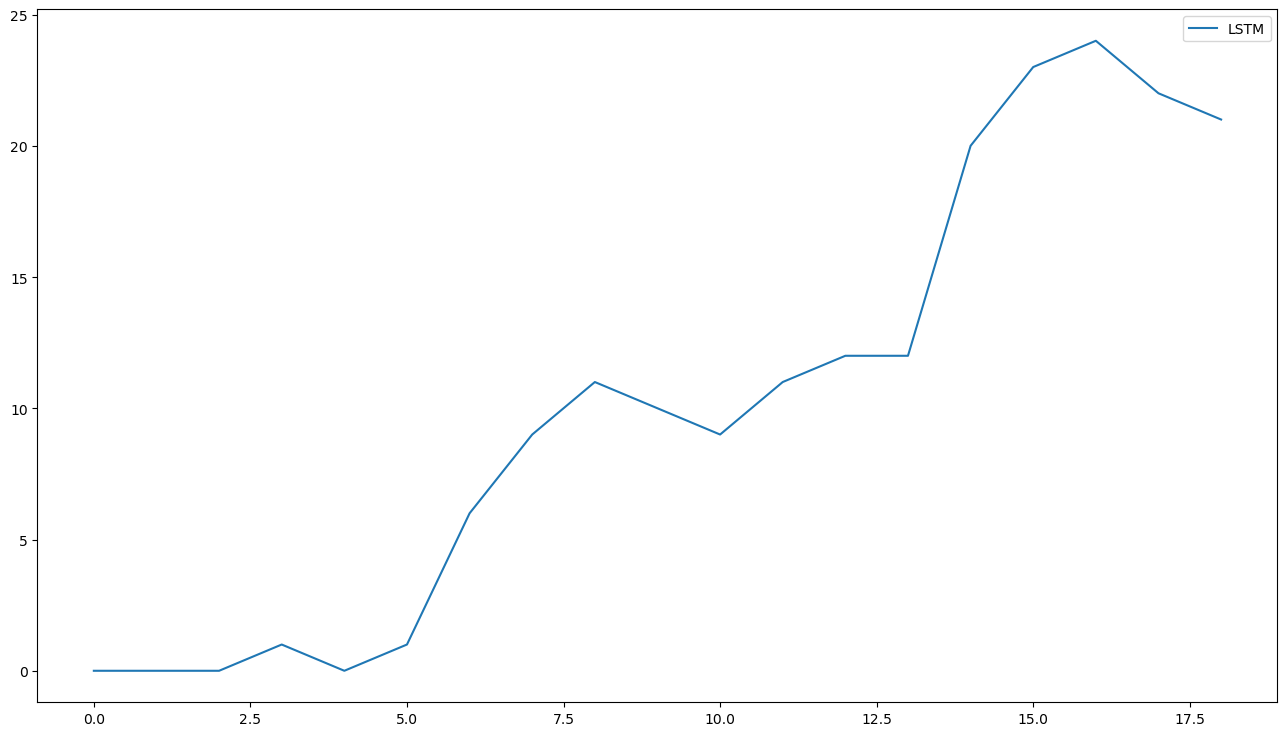

In [93]:
plt.figure(figsize=(16, 9))
plt.plot(FPs_lstm, label="LSTM")
plt.legend()

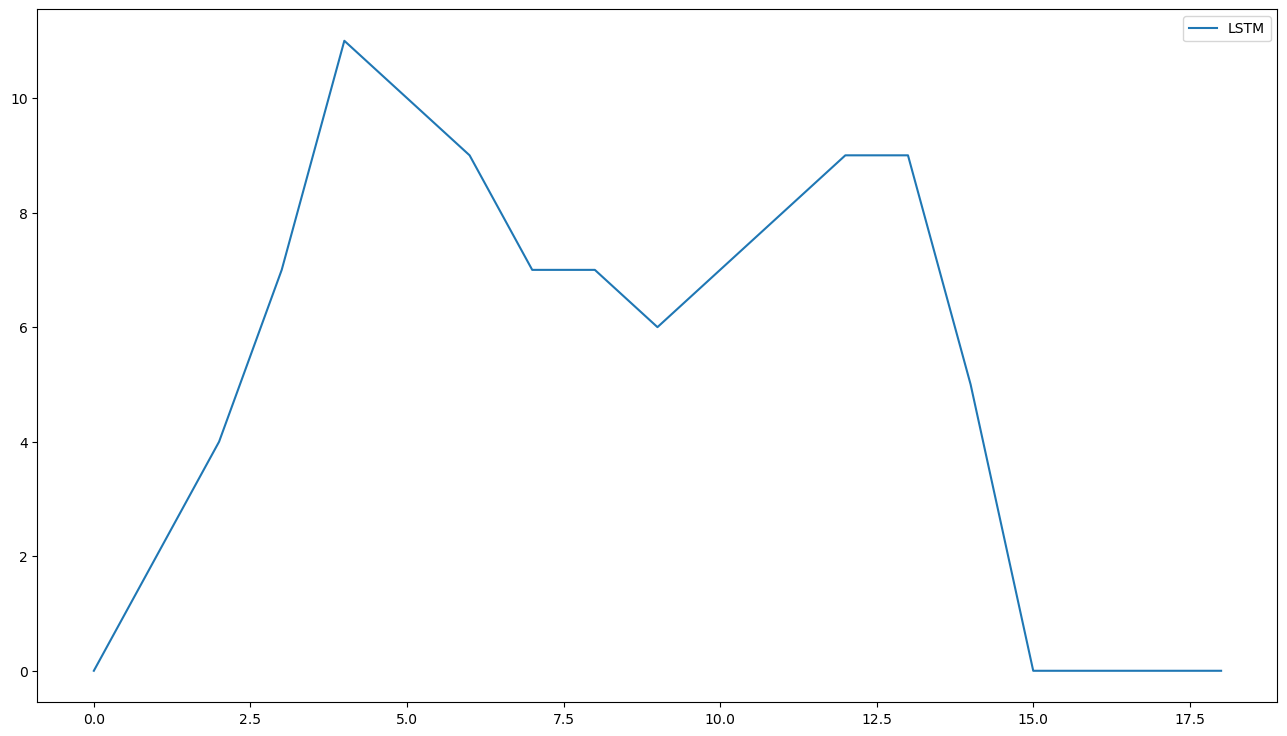

In [94]:
plt.figure(figsize=(16, 9))
plt.plot(FNs_lstm, label="LSTM")
plt.legend()

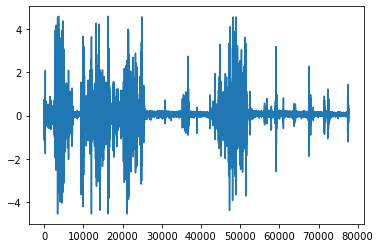

In [33]:
plt.plot(test)

In [39]:
(test > Hs).sum()

34

In [40]:
len(test)

77648

In [7]:
Hs = 3.5791122503726145

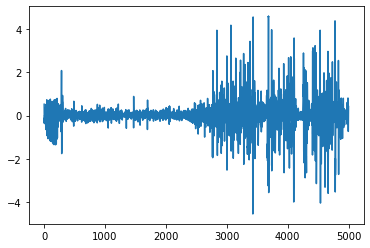

In [36]:
plt.plot(test[:5000])

### WaveNet

In [18]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans        
    

In [19]:
def one_hot(x, num_channels=256, device='cuda'):
    x_o = torch.FloatTensor(x.shape[0], num_channels, x.shape[1])
    x_o = x_o.to(device)
    x_o.zero_().scatter_(1, x.unsqueeze(1), 1)
    return x_o

In [20]:
int_data = amp_to_int(data)
train = int_data[:-55529]
test = int_data[-55529:]

In [21]:
#!L
class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super(CausalConv1d, self).__init__(*args, **kwargs)
        self.padding = ((self.kernel_size[0] - 1) * self.dilation[0],)

    def forward(self, x):
        x = super(CausalConv1d, self).forward(x)
        return x[:, :, :-self.padding[0]]

    



class WaveNet(nn.Module):
    """WaveNet architecture with local conditioning

    https://arxiv.org/pdf/1609.03499.pdf - original paper
    https://arxiv.org/pdf/1702.07825.pdf - appending A for more details
    
    But given implementation has following differences:
    1. tanh is not applied to input embedding
    2. vector is scaled (multiplied 0.5 ** 0.5) between blocks
    3. GRU is used for processing mel spectrogram
    4. GRU output is nearest neighbour apsampled hop_size times
    5. each block has own conditioning projection

    Args:
        num_channels       (int): size of modelled categorical distribution
        residual_channels  (int): hidden vector size
        gate_channels      (int): gate block dimension
        skip_channels      (int): skip-vector size
        pre_channels       (int): dimension before the last layer
        dilation_cycles    (int): number of dilation cycles
        dilation_depth     (int): blocks number in dilation cycle (e.g. if set 10, max dilation = 2^(10-1))
        condition_channels (int): number of mel filters
        hop_size           (int): STFT hop size
    """

    def __init__(self,
                 num_channels,
                 residual_channels,
                 gate_channels,
                 skip_channels,
                 pre_channels,
                 dilation_cycles,
                 dilation_depth,
                 condition_channels,
                 hop_size):
        super(WaveNet, self).__init__()
        
        self.kernel_size = 2
        self.dilations = np.array([
            2 ** (i % dilation_depth) 
            for i in range(dilation_cycles * dilation_depth)
        ])
        
        self.num_channels = num_channels
        self.residual_channels = residual_channels
        self.gate_channels = gate_channels
        self.skip_channels = skip_channels
        self.pre_channels = pre_channels
        self.hop_size = hop_size
        
        
        self.conv_input = nn.Conv1d(
            in_channels=num_channels,
            out_channels=residual_channels,
            kernel_size=1)

        self.blocks_conv_filter = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])

        self.blocks_conv_gate = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])
        
        self.blocks_conv_residual = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=residual_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations) - 1)])
        
        self.blocks_conv_skip = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=skip_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        
        self.conv_out_1 = nn.Conv1d(
            in_channels=skip_channels,
            out_channels=pre_channels,
            kernel_size=1)
        self.conv_out_2 = nn.Conv1d(
            in_channels=pre_channels,
            out_channels=num_channels,
            kernel_size=1)

    def forward(self, x):
        """
        Args:
            x (FloatTensor): continuous audio signal [B x K x T]
            c (FloatTensor): local condition features [B x L x C],
                where L = T // 300

        Returns:
            FloatTensor: output [B x out_channels x T]
        """
        
        x = self.conv_input(x) # equal to x = torch.matmul(x.transpose(1, 2), model.conv_input.weight.squeeze().transpose(0, 1)) + model.conv_input.bias and transpose(1, 2)
        

        x_acc = 0
        for b in range(len(self.dilations)):
            x_filter = self.blocks_conv_filter[b](x)
            x_gate = self.blocks_conv_gate[b](x)


            x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

            x_skip = self.blocks_conv_skip[b](x_hidden)
            x_acc = x_acc + x_skip

            if b < len(self.dilations) - 1:
                x_residual = self.blocks_conv_residual[b](x_hidden)
                x = x + x_residual

            x = x * 0.5 ** 0.5
            

        x = self.conv_out_1(torch.relu(x_acc))
        x = self.conv_out_2(torch.relu(x))

        return x

In [12]:
#!L
WaveNet_model = WaveNet(
    num_channels=256,
    residual_channels=64,
    gate_channels=64,
    skip_channels=128,
    pre_channels=256,
    dilation_cycles=3,
    dilation_depth=8,
    condition_channels=80,
    hop_size=300)
WaveNet_model.to('cuda')

WaveNet(
  (conv_input): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
  (blocks_conv_filter): ModuleList(
    (0): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    (3): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(8,), dilation=(8,))
    (4): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(16,), dilation=(16,))
    (5): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(32,), dilation=(32,))
    (6): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(64,), dilation=(64,))
    (7): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(128,), dilation=(128,))
    (8): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (9): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (10): Ca

In [13]:
def run_epoch(model, x,  optimizer, is_training=False):
    x = torch.LongTensor(x).unsqueeze(0)
    x = x.to('cuda')
    
    if is_training:
        model.train()
    else:
        model.eval()
        
    if is_training:
        optimizer.zero_grad()
    x_o = one_hot(x, model.num_channels)
    #print(x.size())
    #print(x_o.size())
    #print(c.size())
    y = model.forward(x_o).transpose(1, 2)

    loss = nn.functional.cross_entropy(
        y[:, :-1].contiguous().view(-1, y.shape[-1]),
        x[:, 1:].contiguous().view(-1))
    
    if is_training:
        loss.backward()
        optimizer.step()
    
    return loss.detach().item()

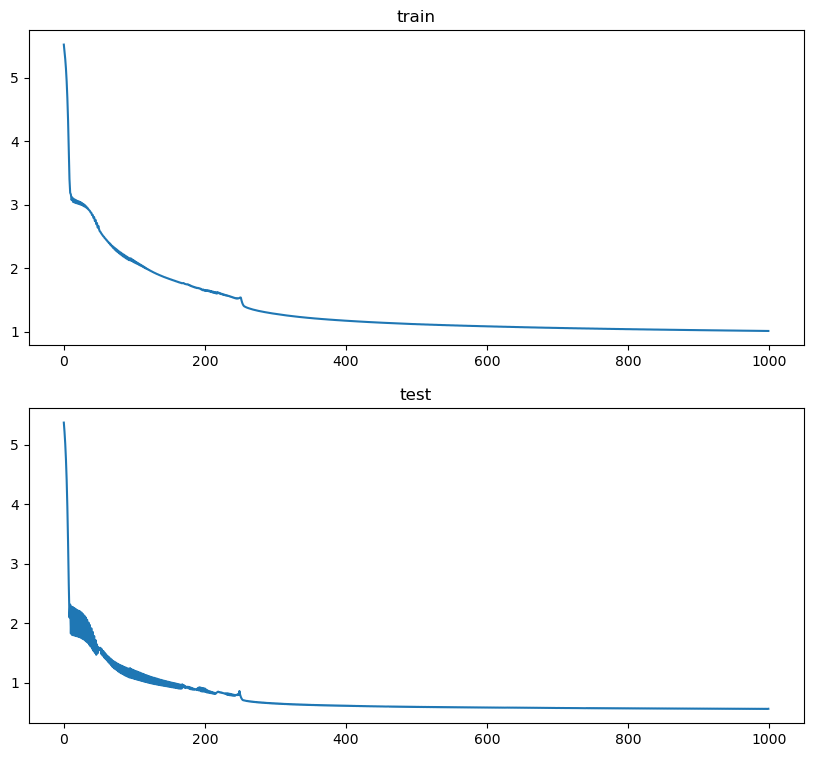

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [22:45<00:00,  1.37s/it]

Epoch[1000/1000] | loss train:1.013512, test:0.563886


In [14]:
epochs = 1000
optimizer = optim.Adam(WaveNet_model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
lr = 0.001

losses_train = []
losses_test = []
best_loss = 10e9
# begin training
for epoch in tqdm(range(epochs)): 
    if epoch > 250:
        lr = 0.0001
#     if epoch > 100:
#         lr = 0.00001

    
    optimizer = optim.Adam(WaveNet_model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(WaveNet_model, train, optimizer, is_training=True)
    loss_val = run_epoch(WaveNet_model, test, optimizer)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(WaveNet_model.state_dict(), "./WaveNetOneMouseFiltered")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [15]:
WaveNet_model.load_state_dict(torch.load("./WaveNetOneMouseFiltered"))

<All keys matched successfully>

In [16]:
def initialize_buffer(model, x):
    model.eval()
    model.to('cpu')
    with torch.no_grad():

        x = one_hot(torch.LongTensor(x).unsqueeze(0), 256, device='cpu')

        #x = model.conv_input(x)
#         print(x.size())
#         assert x.size() == torch.Size([1, 256, 1])

        receptive_field = (model.kernel_size - 1) * model.dilations.sum() + 1
        

        #c = F.pad(c, (receptive_field, 0), "replicate")

        buffer = torch.zeros((40, 64, 520))
        dilations = model.dilations
        
        fill_zero = torch.zeros((1, 256, 1))
        fill_zero[:, 127, :] = 1

        fill_buffer = model.conv_input(fill_zero)
        for i in range(40):
            for j in range(520):
                buffer[i, :, j] = fill_buffer[0, :, 0]

        x_new = x

        res = []
        for i in tqdm(range(x.shape[-1])): #
            next_iter = torch.zeros((40, 64, 1)) # to replace queue

            buffer = torch.cat((buffer, next_iter), 2)

            

            #assert x_new.size() == torch.Size([1, 64, 1])

           
            x_new = model.conv_input(x[:, :, i].unsqueeze(2))                       
            buffer[0, :, -1] = x_new.squeeze()                     
            

            x_acc = 0


            for b in range(len(dilations)):

                input = torch.cat((buffer[b, : ,-dilations[b]-1].unsqueeze(1), buffer[b, : ,-1].unsqueeze(1)), 1)

                x_filter = (input.unsqueeze(0) * model.blocks_conv_filter[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_filter[b].bias

                x_filter = x_filter.unsqueeze(0).unsqueeze(2)


                x_gate = (input.unsqueeze(0) * model.blocks_conv_gate[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_gate[b].bias

                x_gate = x_gate.unsqueeze(0).unsqueeze(2)


                x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

                x_skip = model.blocks_conv_skip[b](x_hidden)

                x_acc = x_acc + x_skip

                if b < len(model.dilations) - 1:
                    x_residual = model.blocks_conv_residual[b](x_hidden)

                    buffer[b+1, :, -1] = (buffer[b, : ,-1].unsqueeze(0).unsqueeze(2) + x_residual).squeeze()
                    buffer[b+1, :, -1] = buffer[b+1, :, -1] * 0.5 ** 0.5


            buffer = buffer[:, :, 1:]



    return buffer

In [17]:
def infer(model, init_buffer, x, l, k=20, mode='sampling'):
    model.eval()
    model.to('cpu')
    with torch.no_grad():

        x = one_hot(torch.LongTensor(x).unsqueeze(0), 256, device='cpu')

        #x = model.conv_input(x)
#         print(x.size())
#         assert x.size() == torch.Size([1, 256, 1])

        receptive_field = (model.kernel_size - 1) * model.dilations.sum() + 1
        

        #c = F.pad(c, (receptive_field, 0), "replicate")

        buffer = init_buffer
        dilations = model.dilations
        

        x_new = x

        res = []
        all_predicts = np.empty((k, 1))
        for i in tqdm(range(l)): #
            #next_iter = torch.zeros((40, 64, 1)) # to replace queue
            all_predicts = np.concatenate((all_predicts, np.zeros((k, 1))), axis=1)
            
            cur_buffer = buffer

            #buffer = torch.cat((buffer, next_iter), 2)

           
            #x_new = model.conv_input(x[:, :, i].unsqueeze(2))
            cur_x_new = x[:, :, i].unsqueeze(2)
            
            for step in range(k):
                
                    
                next_iter = torch.zeros((40, 64, 1)) # to replace queue

                cur_buffer = torch.cat((cur_buffer, next_iter), 2)


                cur_x_new = model.conv_input(cur_x_new)
                cur_buffer[0, :, -1] = cur_x_new.squeeze() #new_x

                x_acc = 0


                for b in range(len(dilations)):

                    input = torch.cat((cur_buffer[b, : ,-dilations[b]-1].unsqueeze(1), cur_buffer[b, : ,-1].unsqueeze(1)), 1)

                    x_filter = (input.unsqueeze(0) * model.blocks_conv_filter[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_filter[b].bias

                    x_filter = x_filter.unsqueeze(0).unsqueeze(2)


                    x_gate = (input.unsqueeze(0) * model.blocks_conv_gate[b].weight).sum(axis=2).sum(axis=1) + model.blocks_conv_gate[b].bias

                    x_gate = x_gate.unsqueeze(0).unsqueeze(2)


                    x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

                    x_skip = model.blocks_conv_skip[b](x_hidden)

                    x_acc = x_acc + x_skip

                    if b < len(model.dilations) - 1:
                        x_residual = model.blocks_conv_residual[b](x_hidden)

                        cur_buffer[b+1, :, -1] = (cur_buffer[b, : ,-1].unsqueeze(0).unsqueeze(2) + x_residual).squeeze()
                        cur_buffer[b+1, :, -1] = cur_buffer[b+1, :, -1] * 0.5 ** 0.5


                cur_buffer = cur_buffer[:, :, 1:]

                cur_x_new = model.conv_out_1(torch.relu(x_acc))
                cur_x_new = model.conv_out_2(torch.relu(cur_x_new))
                
                if step == 0:
                    buffer = cur_buffer

                action = 0
                if mode == "sampling":

                    probs = cur_x_new[0, :, 0]
                    probs = nn.Softmax()(probs)
                    m = Categorical(probs)
                    action = m.sample()
                    
                else:
                    action = np.argmax(cur_x_new[0, :, 0])
                
                all_predicts[step, -1] = action
                if step == k - 1:
                    res.append(action)

                ans = torch.zeros((1, 256, 1))
                ans[0, action, 0] = 1
                cur_x_new = ans


    res = np.array(res)

    return res, all_predicts

In [18]:
init_buffer = initialize_buffer(WaveNet_model, train[-1000:])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.70it/s]


In [19]:
step20_predict, wave_net_predicts = infer(WaveNet_model, init_buffer, test, len(test), k=19, mode='argmax')

100%|██████████████████████████████████████████████████████████████████████████| 55529/55529 [4:27:42<00:00,  3.46it/s]


In [20]:
#np.save("predicts/wavenet_predict_mice_filtered", wave_net_predicts)

In [22]:
wave_net_predicts = np.load("predicts/wavenet_predict_mice_filtered.npy")

In [23]:
def CalcRMSE(x, y):
    return (((x - y)**2).mean())**0.5

In [25]:
wavenet_rmses = []
wavenet_rmses.append(CalcRMSE(int_to_amp(wave_net_predicts[:, 1:][0], data, n=256), data[-55529:]))
for i in tqdm(range(1, 19)):
    wavenet_rmses.append(CalcRMSE(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-i], data[-55529 + i:]))

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 3609.04it/s]


In [32]:
CalcRMSE(data[-55529:], np.array([mean] * 55529))

0.12372231376688284

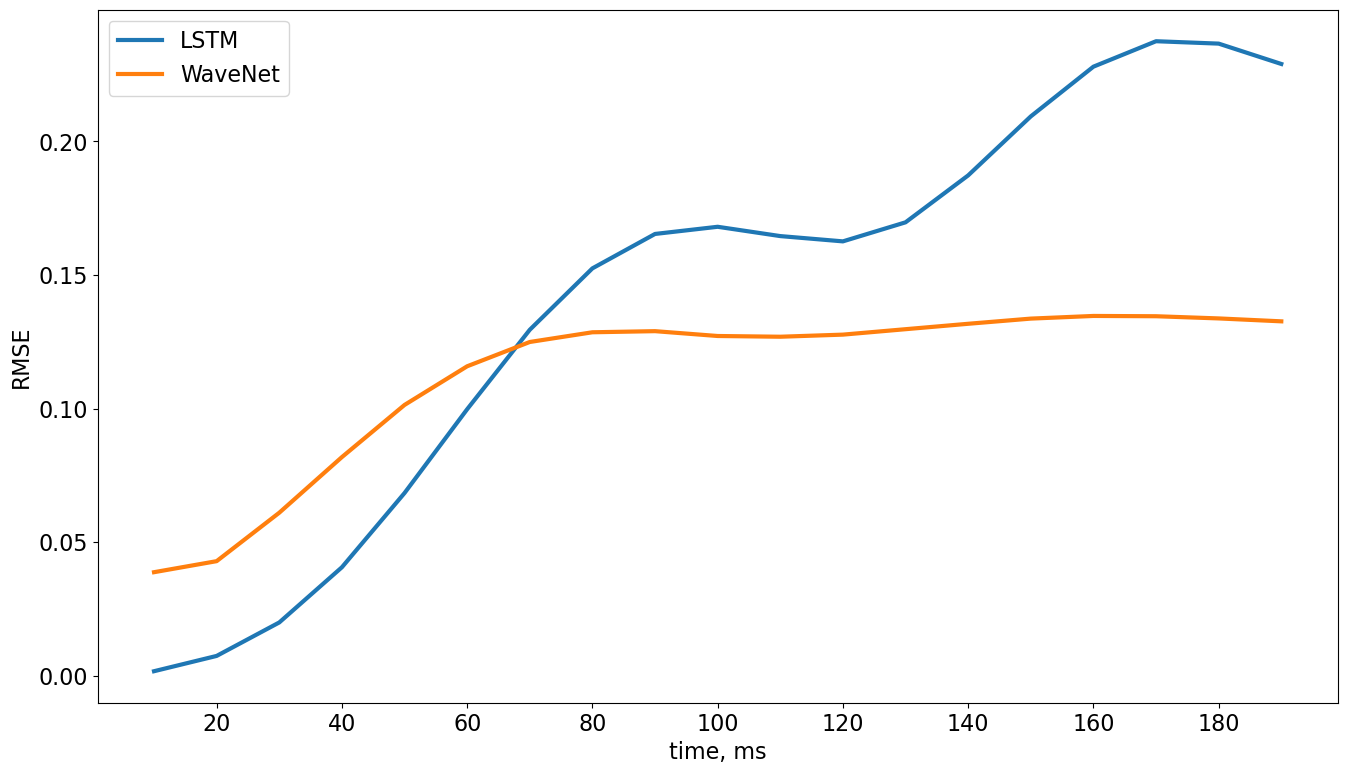

In [111]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(10, 200, 10)), rmse_chaos, label="LSTM", linewidth = 3)
ax.plot(list(range(10, 200, 10)), wavenet_rmses, label="WaveNet", linewidth = 3)



ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("time, ms",  fontsize = 16)
ax.legend(fontsize = 16)

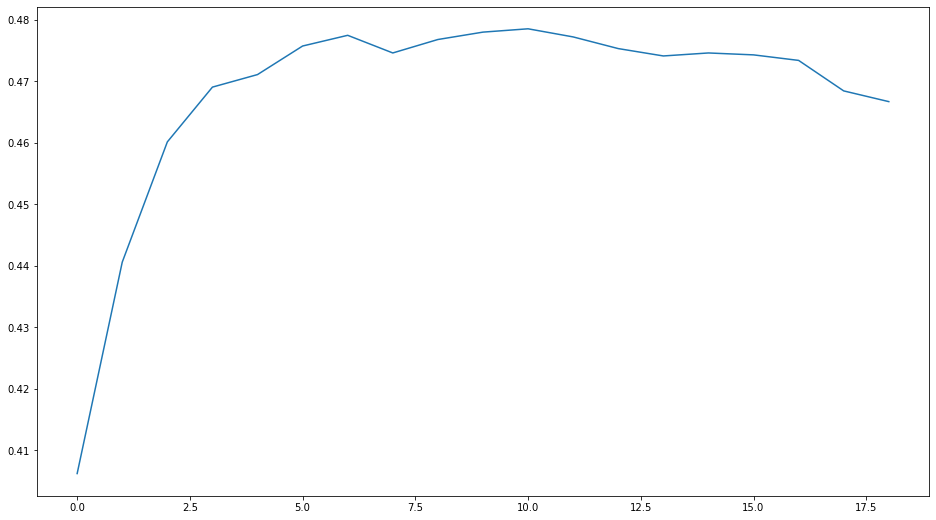

In [18]:
plt.figure(figsize=(16, 9))
plt.plot(wavenet_rmses)

In [58]:
def Plt_lstm(k):
    #k = 5
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    

    ax.plot(list(range(0, 60000, 10)), lstm_test[20+k-1 + 24000: 20+k-1 + 30000], linewidth = 3, label='истинные')
    ax.plot(list(range(0, 60000, 10)), lstm_predicts[k-1][24000:30000],  
            linestyle = (0, (5, 10)), linewidth = 3, label='предсказанные', color="red")
    #ax.plot(list(range(0, 10000, 10)), lstm_predicts[k-1][:1000],  linestyle = '--', linewidth = 3, label='предсказанные', color="red")
    
    ax.legend(fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title('LSTM')
    ax.set_ylabel("V, мВ",  fontsize = 16)
    ax.set_xlabel("время, мс",  fontsize = 16)
    
    
    plt.show()

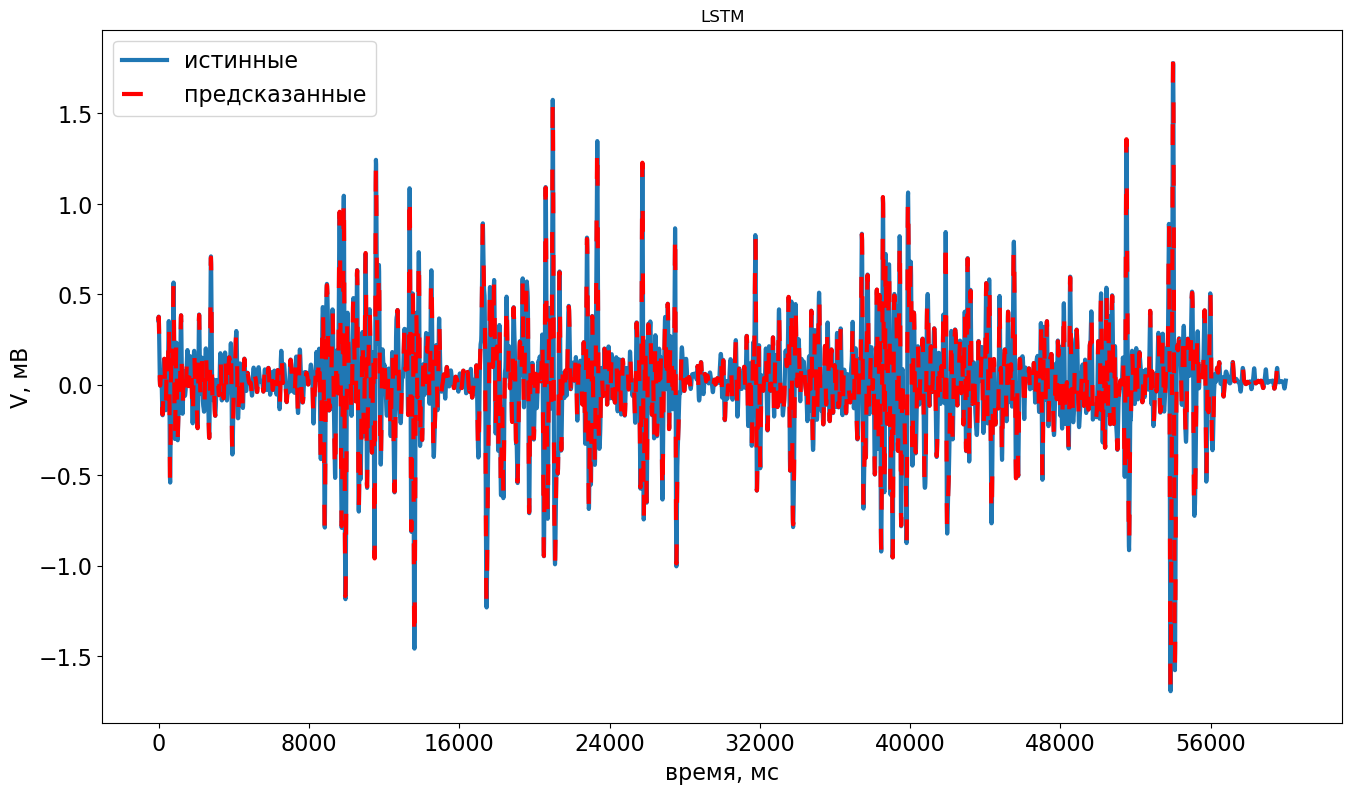

In [59]:
Plt_lstm(1)

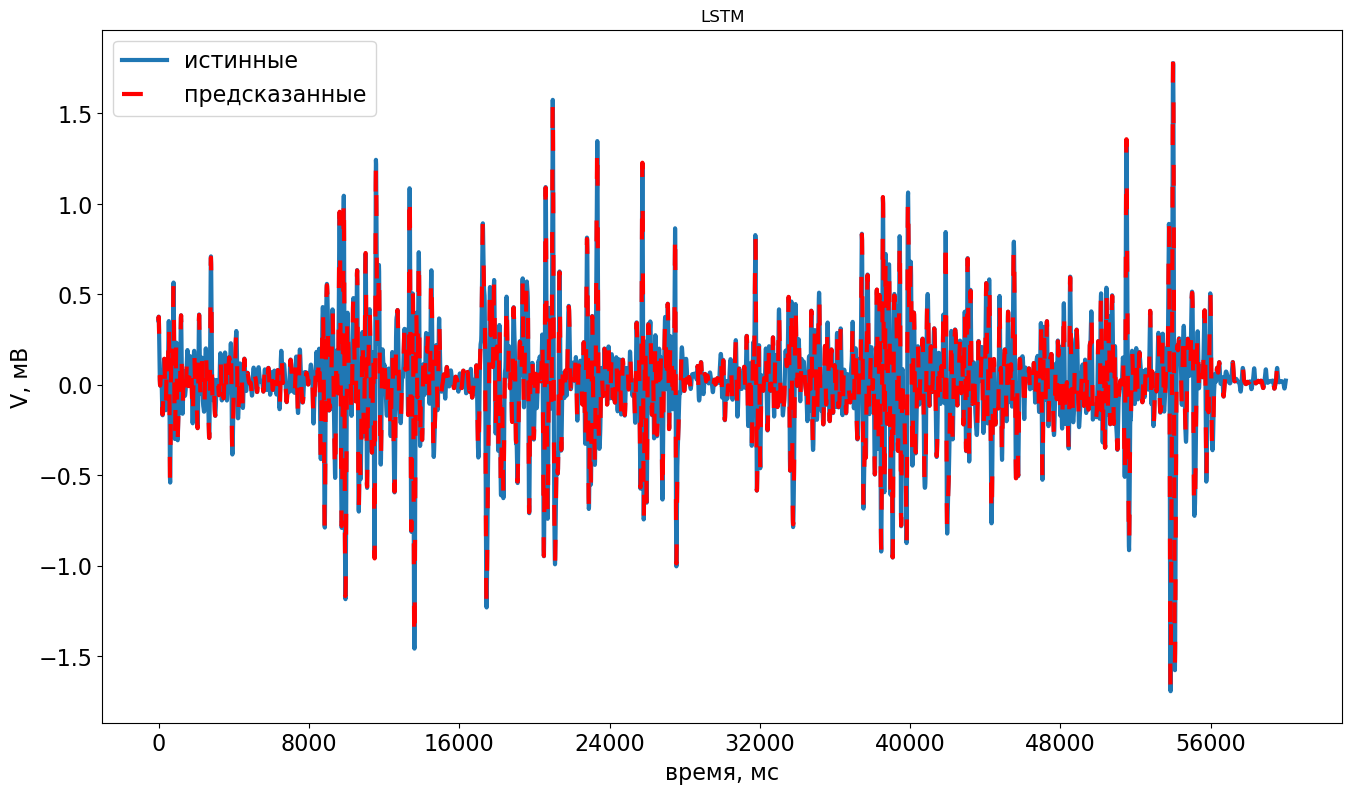

In [58]:
Plt_lstm(1)

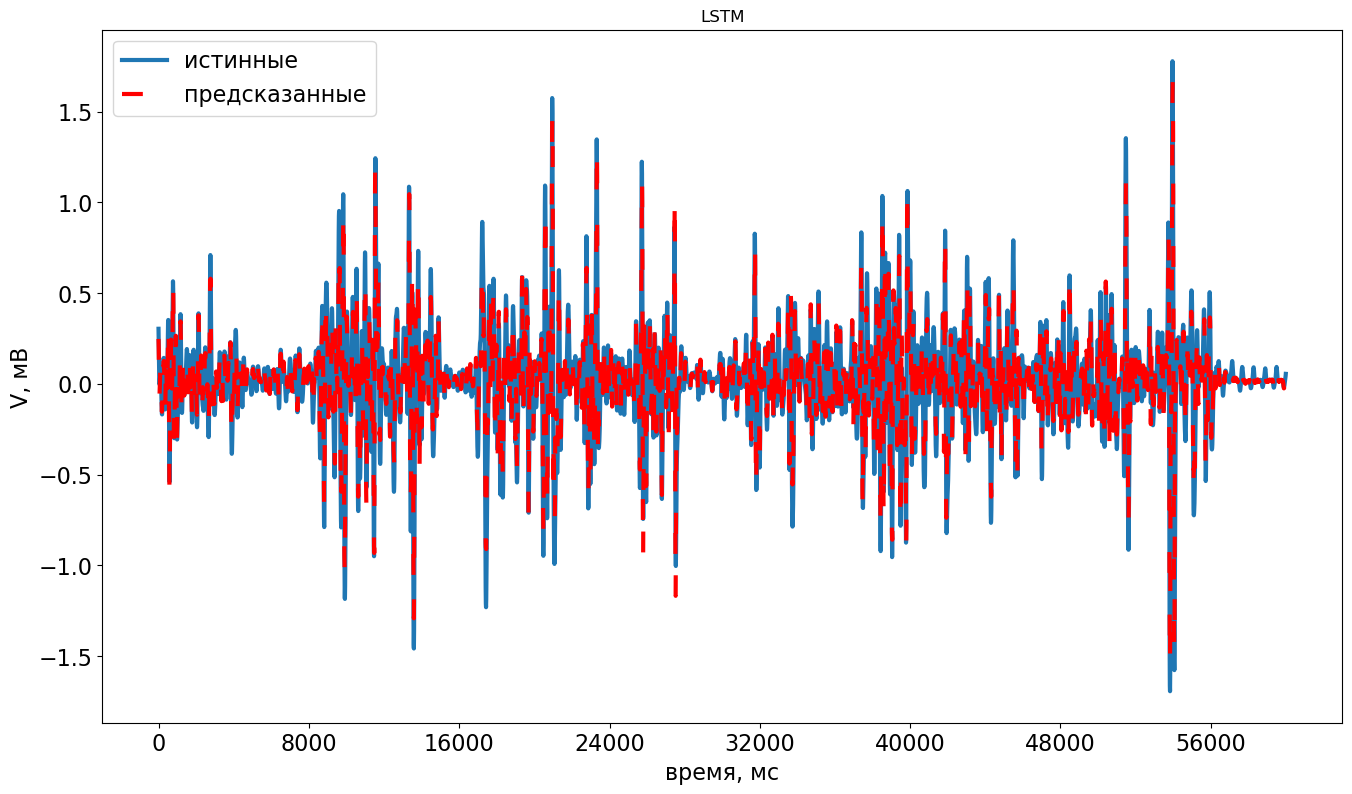

In [63]:
Plt_lstm(4)

In [65]:
def Plt(k):
    #k = 5
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.plot(list(range(0, 60000, 10)), data[-55529 + k + 24000:-55529 + k + 30000], linewidth = 3, label='истинные')
    ax.plot(list(range(0, 60000, 10)), int_to_amp(wave_net_predicts[:, 1:][k-1], data, n=256)[24000:30000],  
             linestyle = (0, (5, 10)), linewidth = 3, label='предсказанные', color="red")
  
    
    ax.legend(fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title('WaveNet')
    ax.set_ylabel("V, мВ",  fontsize = 16)
    ax.set_xlabel("время, мс",  fontsize = 16)
    
    
    plt.show()

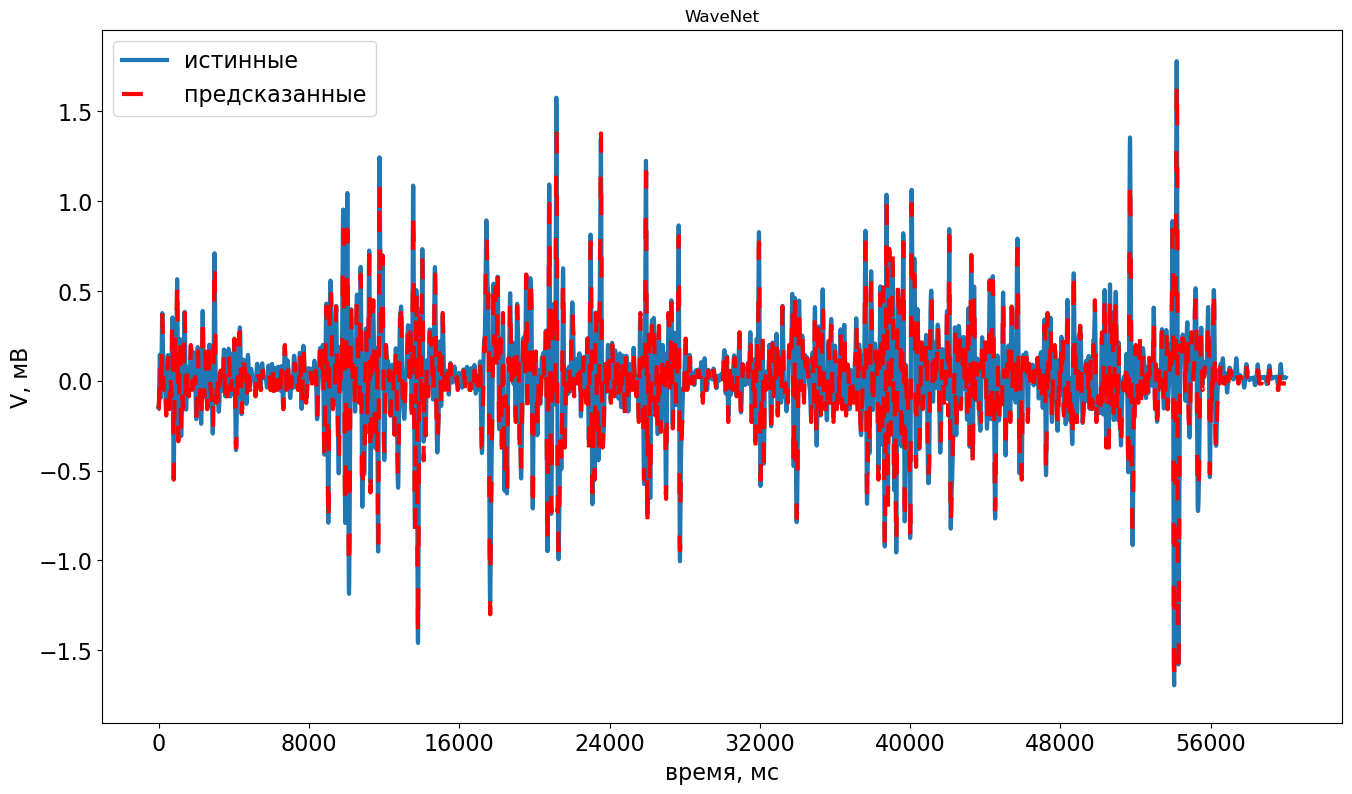

In [66]:
Plt(1)

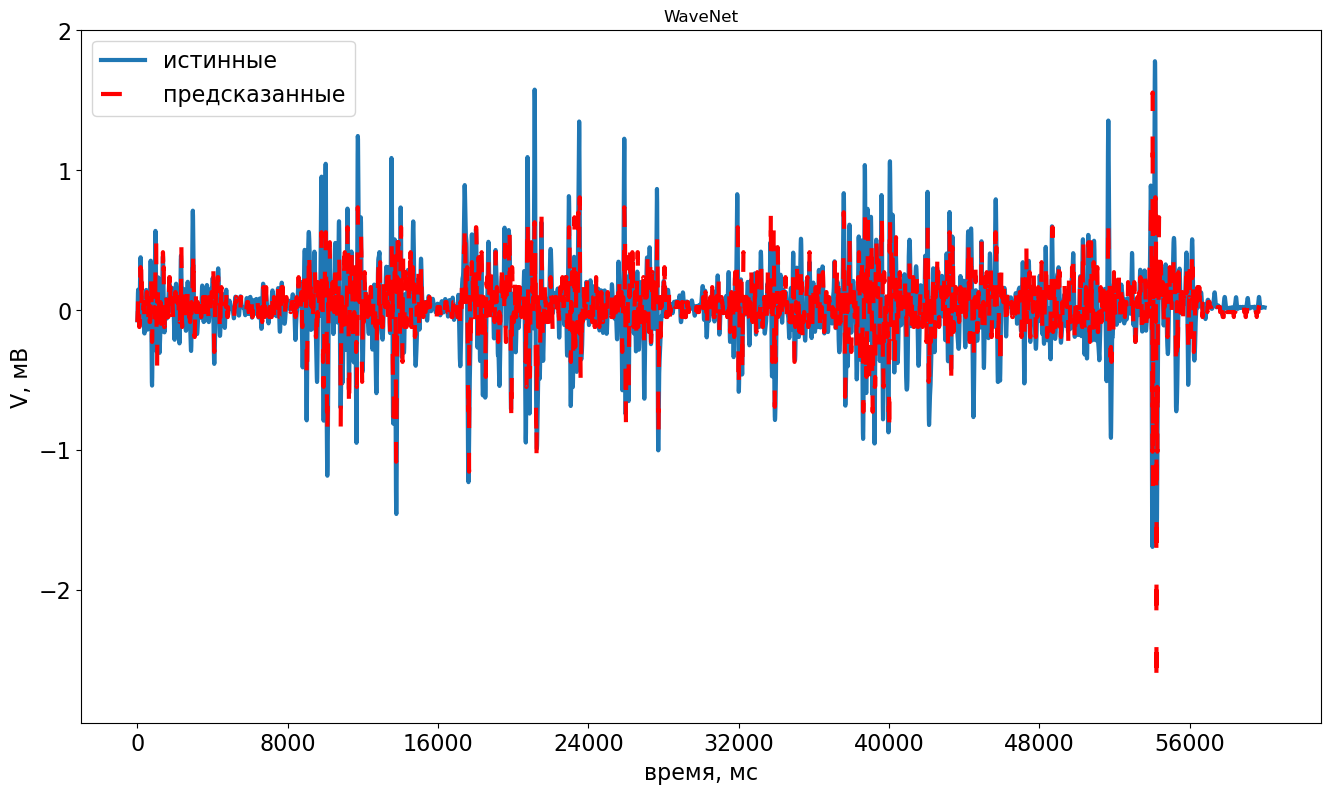

In [67]:
Plt(4)

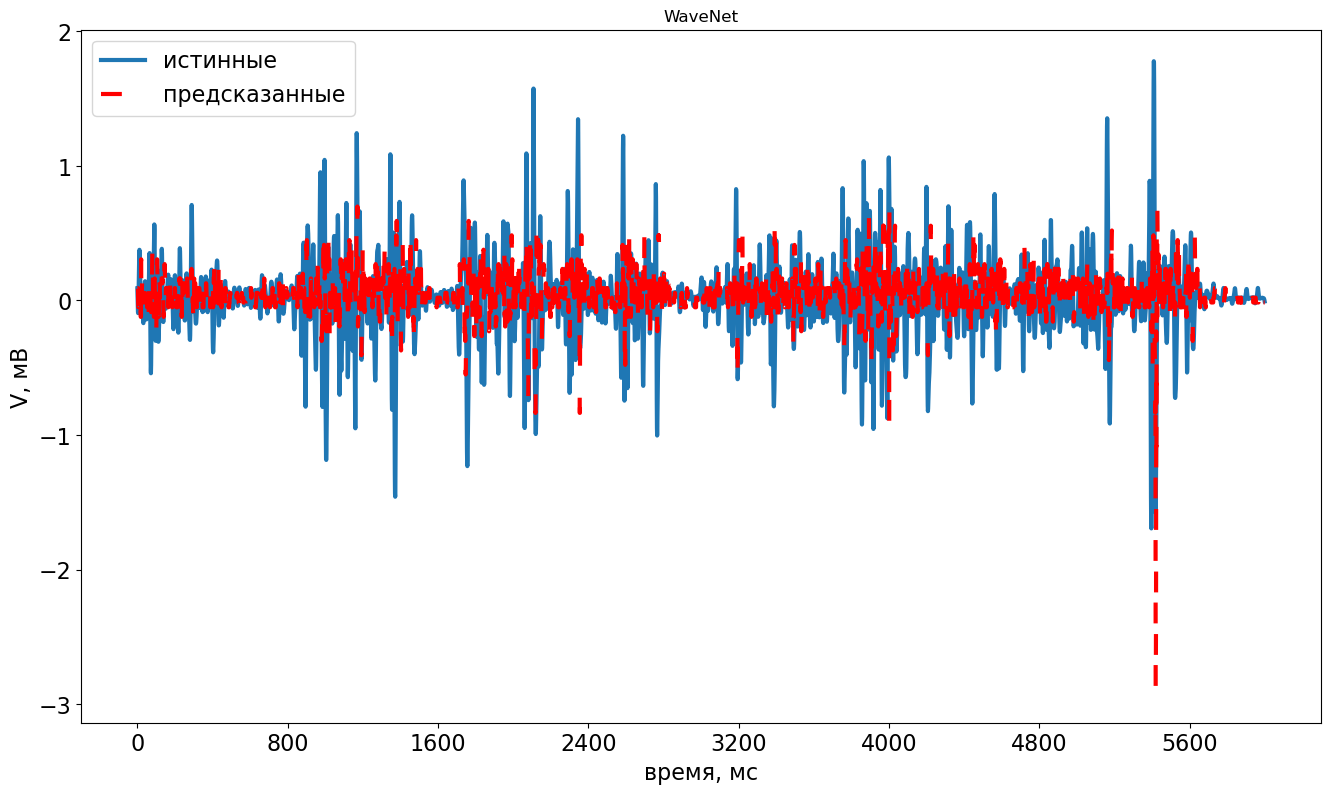

In [64]:
Plt(10)

In [95]:
test_right_part = (len(test)- 20)%64

TPs_wave = []
for i in range(19):
    TP_wave, _ = Calc_TP(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-1-i], data[-55529 :][i+1:], i+1, 50, 5 + i)
    TPs_wave.append(TP_wave)
    

In [96]:
test_right_part = (len(test)- 20)%64
FNs_wave = []

for i in range(19):
    
    FN_wave, _ = Calc_FN(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-1-i], data[-55529 :][i+1:], i+1, 50, 5 + i)
    FNs_wave.append(FN_wave)
    

In [97]:
test_right_part = (len(test)- 20)%64
FPs_wave = []

for i in range(19):

    FP_wave, _ = Calc_FP(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-1-i], data[-55529 :][i+1:], i+1, 50, 5 + i)
    FPs_wave.append(FP_wave)
    

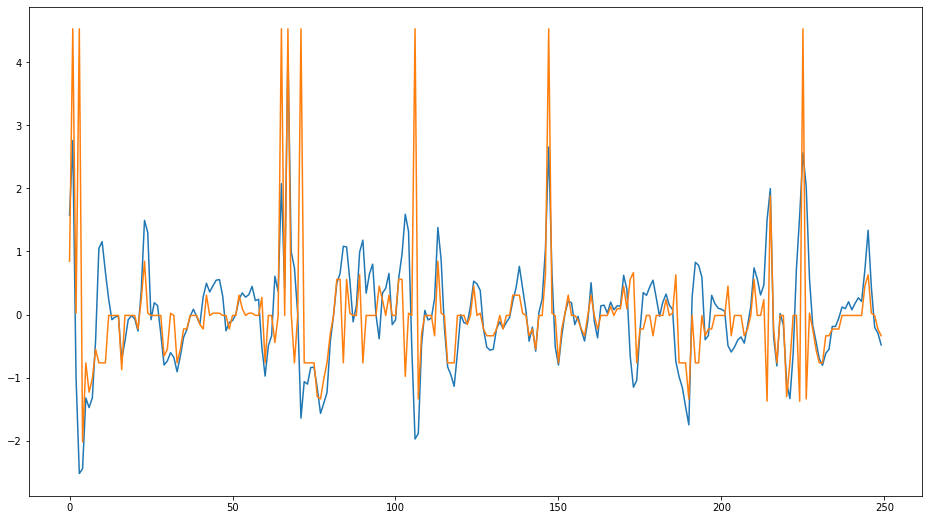

In [52]:
plt.figure(figsize=(16, 9))

plt.plot(data[-77648 :][3000:3250])
plt.plot(int_to_amp(wave_net_predicts[:, 1:][0], data, n=256)[3000:3250])

In [ ]:
plt.plot(data[-77648 :][3000:3250])

In [55]:
data[-77648 :][3000:3250].max()

4.178

Очень много FP, за ними скрываются TP

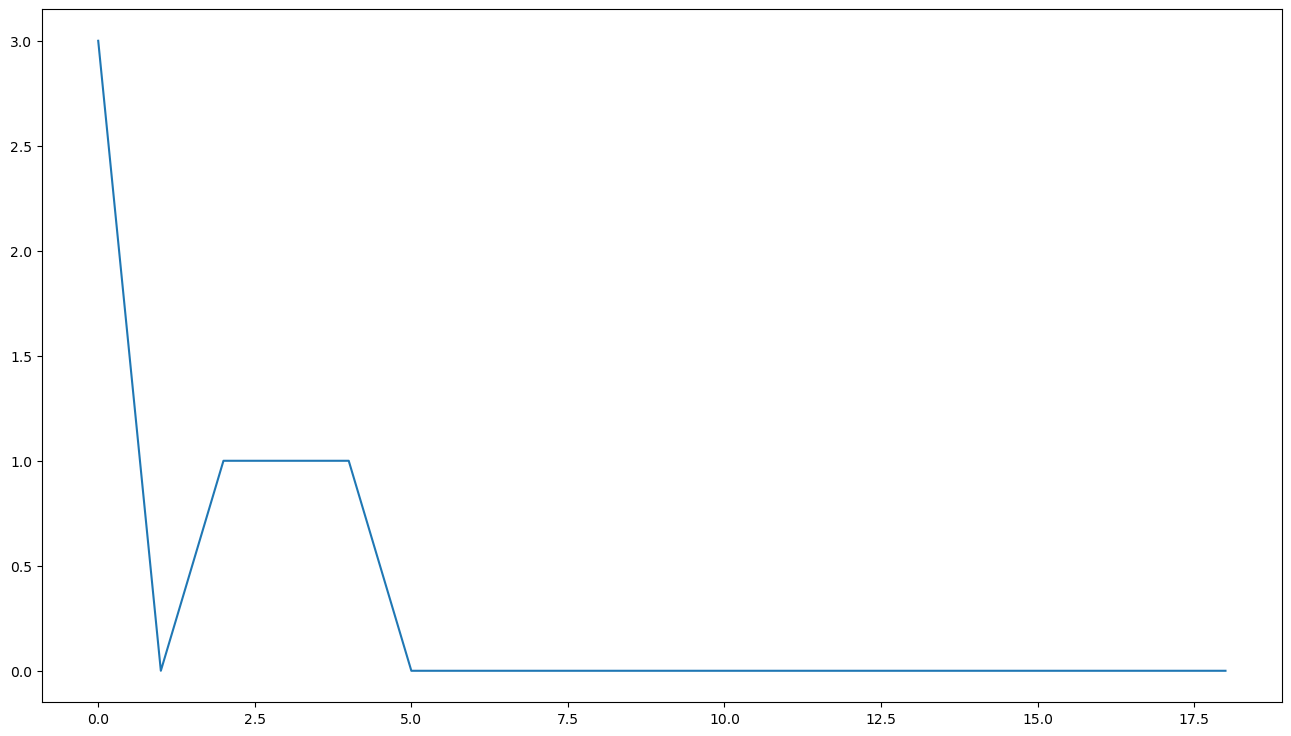

In [98]:
plt.figure(figsize=(16, 9))
plt.plot(TPs_wave)

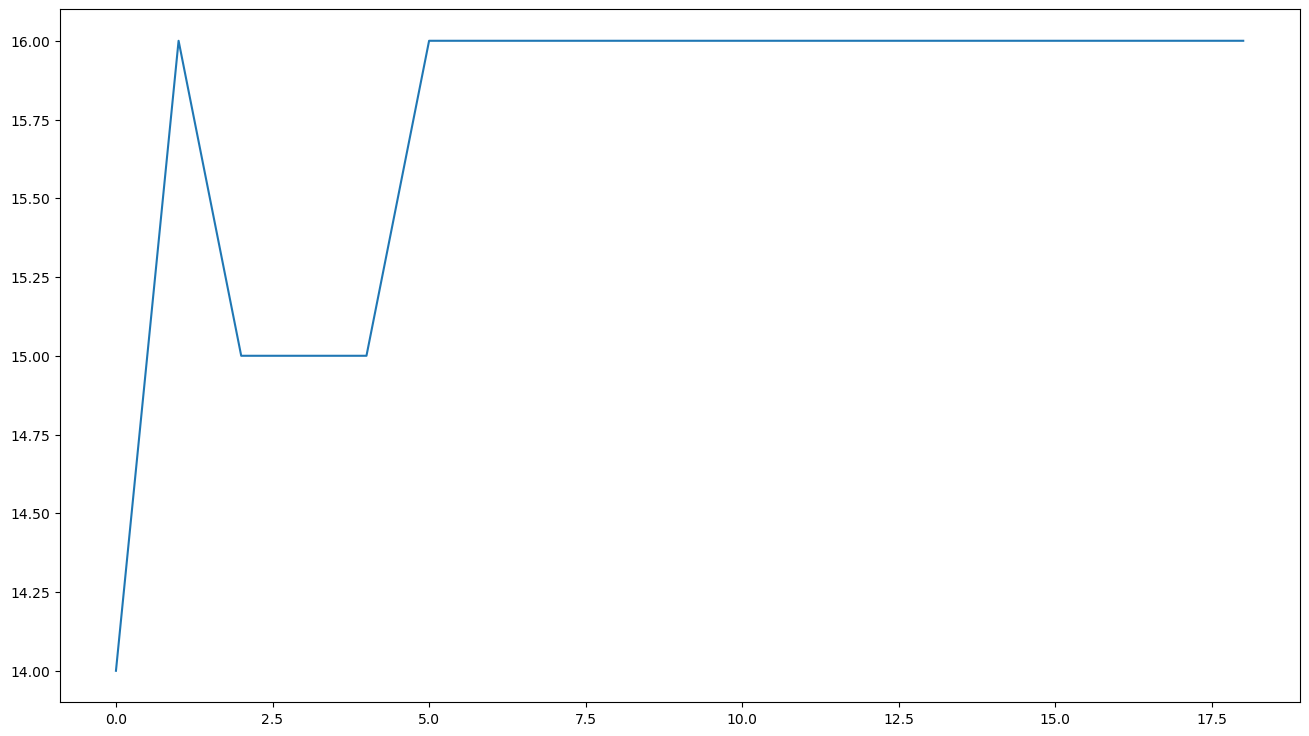

In [99]:
plt.figure(figsize=(16, 9))
plt.plot(FNs_wave)

In [101]:
Hs

1

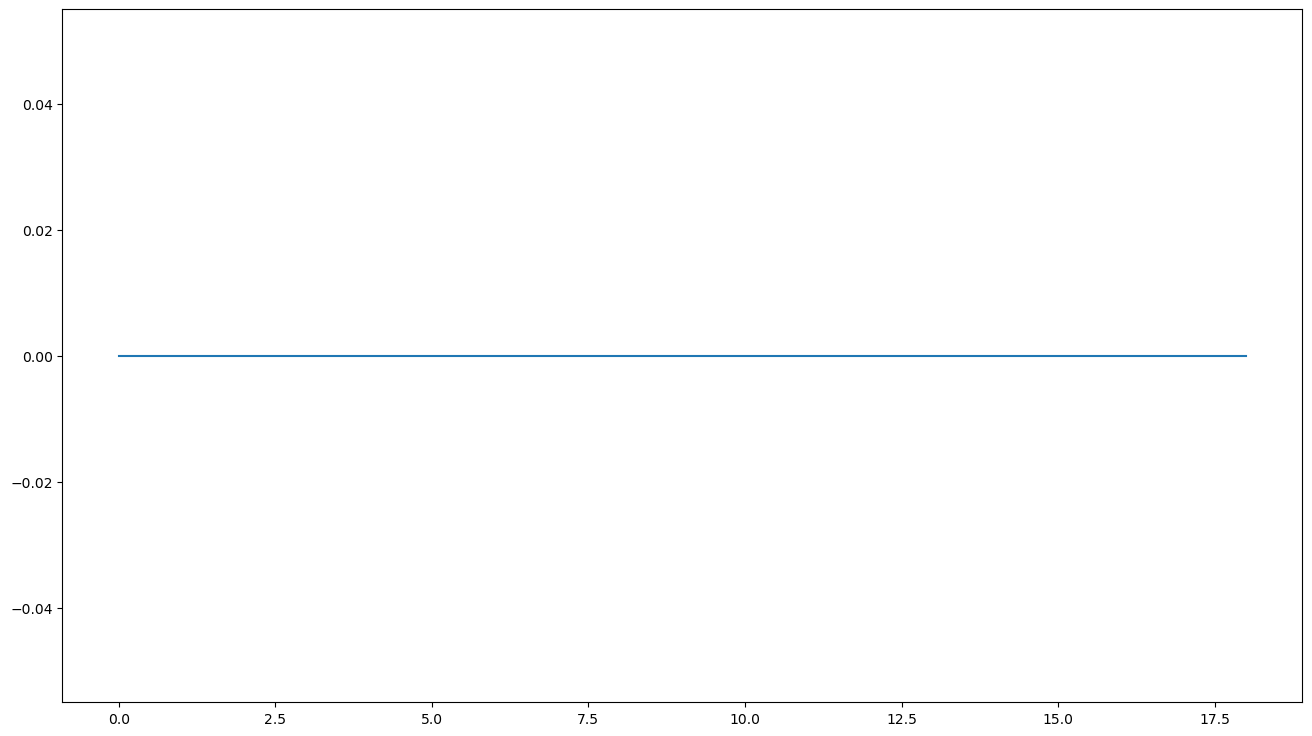

In [100]:
plt.figure(figsize=(16, 9))
plt.plot(FPs_wave)

In [105]:
pres_wave = []
for i in range(len(TPs_wave)):
    if (TPs_wave[i]):
        pres_wave.append(TPs_wave[i] / (TPs_wave[i] + FPs_wave[i]))
    else:
        pres_wave.append(0)

In [106]:
pres_wave

[1.0, 0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [107]:
acc_wave = []
for i in range(len(TPs_wave)):
    if (TPs_wave[i]):
        acc_wave.append(TPs_wave[i] / (TPs_wave[i] + FNs_wave[i]))
    else:
        acc_wave.append(0)

In [108]:
acc_wave

[0.17647058823529413,
 0,
 0.0625,
 0.0625,
 0.0625,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]